In [ ]:
import sys
sys.path.append('n_dim_code/')
sys.path.append('/opt/miniconda3/lib')
sys.path.append('/opt/miniconda3/lib/python3.7/site-packages')

import os
import pickle
import numpy as np
import math
import warnings

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle, FancyBboxPatch
from matplotlib import patches
from matplotlib import text as mtext

from collections import defaultdict as ddict
from collections import OrderedDict as odict
from collections import namedtuple as nt

from scipy.optimize import minimize_scalar, root
from scipy.optimize import broyden1 as minimize
from scipy.interpolate import interp1d
from scipy.integrate import quad, simpson
from scipy.special import dawsn, erfi
from scipy import stats

from math import erf
from copy import deepcopy

from common_functions import make_figure_set_width, CurvedText, variance_star, folded_sojourn_time
### folded_sojourn_time was defined with S but now its with a
from common_functions import fixation_probability_steady_state as fixation_prob_laura
N = 5000


In [ ]:

        
### Calculate the fixation probability from Hayward and Sella (2022)
def fixation_prob_laura(a,x):
    return (erf(a/2) - erf(a/2*(1 - 2*x)))/(2*erf(a/2))

def fixation_prob_after_shift_laura(S,x,sign,sigma2,shift):
    if S == 0:
        return x
    a = np.sqrt(S)*sign
    dx = a*fd(S,sign,sigma2,shift,x)*x*(1-x)
    xx = min(1,max(0,x + dx))
    fix = fixation_prob_laura(a=a,x=xx)
    return fix

def fd(S,sign,sigma2,shift,x):
    a = np.sqrt(S)*sign
    useful = np.exp(a*shift/sigma2)-1
    return 1/a*useful/(1+x*useful)

def fixation_prob_given_S_laura(S,sign,sigma2,shift):
    
    top = quad(lambda x: folded_sojourn_time(S=S,x=x)*fixation_prob_after_shift_laura(S=S,x=x,sigma2=sigma2,sign=sign,shift=shift),0,1/2,points=[1/(2*N)])[0]
    bottom = quad(lambda x: folded_sojourn_time(S=S,x=x),0,1/2,points=[1/(2*N)])[0]
    return top/bottom

### calculate ppf of frequency from stationary distribution
def ppf_x_helper(S,y,N=5000):
    if y < 0:
        return y
    elif y > 1/2:
        return 2*y
    else:
        top = quad(lambda x: folded_sojourn_time(S=S,x=x),0,y,points=[1/(2*N)])[0]
        bottom = quad(lambda x: folded_sojourn_time(S=S,x=x),0,1/2,points=[1/(2*N)])[0]
        return top/bottom
    
def ppf_x(S,p,initial_value=0.1):
    return root(lambda y: ppf_x_helper(S=S,y=y)-p,initial_value).x[0]

# create a dictionary of ppf values for a range of probabilities
def generate_ppf(S):
    ppf_dict = {}
    previous_x = 1/(2*N)
    for i in np.linspace(0,1,200):
        if i == 0:
            ppf_dict[i] = 0
        elif i == 1:
            ppf_dict[i] = 0.5
        previous_x = ppf_x(S,i,previous_x)
        ppf_dict[i] = previous_x
    return ppf_dict

# estimate ppf from ppf dictionary
def get_frequency_from_ppf_dict(ppf_dict,p):
    p_min = 0
    y_min = 0
    p_max = 1
    y_max = 1
    for pp,yy in ppf_dict.items():
        if pp <= p and pp >= p_min:
            p_min = pp
            y_min = yy
        if pp >= p and pp <= p_max:
            p_max = pp
            y_max = yy
    slope = (y_max - y_min) / (p_max - p_min)
    return y_min + slope * (p - p_min)

# define fitness in terms of phenotype z
def fitness(z):
    return np.exp(-(z)**2/(2*2*N))

# define expected delta x for a given S, x, shift, and sign using fitness function
def expected_delta_x(S,x,shift,sign=1):
    genotype_fitness = {}
    u = -shift
    a = sign*np.sqrt(S)
    z_func = lambda n: u + a*(n-2*x)
    for n in [0,1,2]:
        if n == 0:
            p = (1-x)**2
        elif n == 1:
            p = 2*x*(1-x)
        elif n == 2:
            p = x**2
        z = z_func(n)
        genotype_fitness[n] = (fitness(z),p)
    
    mean_fitness = sum([genotype_fitness[n][0]*genotype_fitness[n][1] for n in [0,1,2]])
    mean_change = 0
    for n in [1,2]:
        temp = genotype_fitness[n][0]*genotype_fitness[n][1]
        if n == 1:
            temp = temp/2
        mean_change += temp
    return mean_change/mean_fitness - x

# run a stochastic recursion for a given S, x0, shift, sigma2, sign, and N
def recursion(S,x0,shift,sigma2,sign=1,N=5000,fix_prob=1):
    a = np.sqrt(S)*sign
    D = shift
    x = x0
    Vs = 2*N
    t = 0

    while x < 1 and x > 0:
        dx = a/Vs*(D-a*(1/2-x))*x*(1-x)
        dx = expected_delta_x(S,x,shift=D)
        new_x = min(1,max(0,x+dx))
        new_x = np.random.binomial(2*N,new_x)/(2*N)
        realized_dx = new_x - x

        D += -D*sigma2/Vs - realized_dx*2*a
        x = new_x
        t += 1
    if x > 1:
        raise ValueError
    elif x >= fix_prob:
        return 1
    else:
        return 0

# functions for calculating the time to establishment
def b(z,shift,a):
    return np.float128(z*(1-z)/(2*N))

def aa(z,shift,a):
    Vs = 2*N
    return np.float128(a/Vs*z*(1-z)*(shift-a*(1/2-z)*(1-shift**2/Vs)))

def psi(y,shift,a):
    integral = quad(lambda z: aa(z,shift,a)/b(z,shift,a),0,y)[0]
    value = np.exp(-2*integral)
    return np.exp(-2*integral)

def p1(p,shift,a):
    top = quad(lambda y: psi(y,shift,a),0,p)[0]
    bottom = quad(lambda y: psi(y,shift,a),0,1)[0]
    return top/bottom

def p0(p,shift,a):
    return 1-p1(p,shift,a)

def t_star(x,p,shift,a):
    g = b(x,shift,a)*psi(x,shift,a)
    f = 2*p1(x,shift,a)

    if x <= p:
        h = p0(x,shift,a)/p1(p,shift,a)
        i = quad(lambda y: psi(y,shift,a),0,x,points=[1/(2*N)])[0]
    else:
        h = 1
        i = quad(lambda y: psi(y,shift,a),x,1,points=[1/(2*N)])[0]
    return f*h*i/g

def mean_t_til_establishment(p,shift,a):
    establishment_x = find_xc_for_minimum_establishment_prob(S=a**2,shift=shift,minimum_establishment_prob=0.95)
    if p > establishment_x:
        return 0
    g = quad(lambda x: t_star(x=x,p=p,shift=shift,a=a),0.0,establishment_x,points=[p])
    return g[0]

### i think these can be deleted
def get_recursion_est(S,x0,D0,sigma2,sign,x_est,N=5000):

    x = x0
    D = D0
    a = sign*np.sqrt(S)
    t = 0
    Vs = 2*N
    t_est = np.nan
    x_trajectory = [x0]
    est = False

    while x < 1 and x > 0 and est == False:
        if x > x_est and est == False:
            t_est = t
            est = True
        a = np.sqrt(S)*sign
        # dx = a/Vs*x*(1-x)*(D-a*(1/2-x)*(1-D**2/Vs))
        dx = expected_delta_x(S,x,shift=D)
        x = np.random.binomial(2*N,min(1,max(0,x+dx)))/(2*N)
        D += - D/Vs*sigma2 - 2*a*dx
        x_trajectory.append(x)
        t += 1

    return est,t_est

def find_t_est(shift,results):
    shift_max = 1000
    shift_min = 0
    t_min = 0
    t_max = 0
    for shift_key in results.keys():
        if shift_key <= shift and shift_key >= shift_min:
            shift_min = shift_key
            t_min = results[shift_key]
            
        if shift_key >= shift and shift_key <= shift_max:
            shift_max = shift_key
            t_max = results[shift_key]
    if np.isnan(t_max):
        t_max = 0
    if np.isnan(t_min):
        t_min = 0
    if shift_max == shift_min:
        return t_min
    else:
        slope = (t_max-t_min)/(shift_max-shift_min)
        x = shift-shift_min
        return t_min + slope*x

def find_t_est_seg(shift,x0,results):
    shift_max = 1000
    shift_min = 0
    x_min = 0
    x_max = 1
    t_min = 0
    t_max = 0

    ### find the right shift dicts
    for shift_key in results.keys():
        if shift_key <= shift and shift_key >= shift_min:
            shift_min = shift_key
            shift_min_dict = results[shift_key]
            
        if shift_key >= shift and shift_key <= shift_max:
            shift_max = shift_key
            shift_max_dict = results[shift_key]
    
    ### find the right x values
    for x in shift_min_dict.keys():
        if x <= x0 and x >= x_min:
            x_min = x
        if x >= x0 and x <= x_max:
            x_max = x
    
    if shift_max != shift_min:
        slope_x_max = (shift_max_dict[x_max] - shift_min_dict[x_max])/(shift_max-shift_min)
        t_x_max = shift_min_dict[x_max] + slope_x_max*(shift-shift_min)
        slope_x_min = (shift_max_dict[x_min] - shift_min_dict[x_min])/(shift_max-shift_min)
        t_x_min = shift_min_dict[x_min] + slope_x_min*(shift-shift_min)
    else:
        t_x_max = shift_max_dict[x_max]
        t_x_min = shift_min_dict[x_min]
    
    if x_max == x_min:
        return t_x_min
    else:
        slope = (t_x_max - t_x_min)/(x_max-x_min)
        return t_x_min + slope*(x0-x_min)
    
###

# calculate the proportion of fixed alleles and the standard error of the proportion
def analyze_simulation_results(results):
    results_analyzed = {}
    for shift in results.keys():
        n = len(results[shift])
        p_fix = np.mean([int(i==1) for i in results[shift]])
        p_error = 2*(np.var([int(i==1) for i in results[shift]])/n)**(0.5)
        results_analyzed[shift] = (p_fix,p_error)
    return results_analyzed

# calculate expected S
def expected_S(S,x,shift,sign=1):
    dx = expected_delta_x(S,x,shift,sign)
    s = dx/(x*(1-x))
    a = np.sqrt(S)*sign
    s_e = a*(shift-a*(1/2-x))/(2*N)
    return s,s_e
    
### calculate the establishment probability
def establishment_prob(S,shift,x,x_est=1,sign=1):
    x_est=1
    Sx = lambda x: expected_S(S=S,x=x,shift=shift)[0]
    if Sx(x) < 0: return 0
    establishment_prob_l = lambda x: (1 - np.exp(-4*N*Sx(x)*x))/(1 - np.exp(-4*N*Sx(x)*x_est))
    return establishment_prob_l(x)
    
### find x to have a minimum establishment probability
def find_xc_for_minimum_establishment_prob(S,shift,minimum_establishment_prob,x_initial = 0.001,sign=1):

    if x_initial > 0.4:
        return 0.4
        
    sol = root(lambda x: establishment_prob(S=S,shift=shift,x=x,sign=sign)-minimum_establishment_prob,x_initial)
    if not sol.success:
        return find_xc_for_minimum_establishment_prob(S=S,shift=shift,minimum_establishment_prob=minimum_establishment_prob,x_initial = x_initial*2,sign=sign)
    else:
        return sol.x[0]

### Deterministic recursion to check for fixation
def get_recursion_deterministic(S,x0,D0,sigma2,fix_freq=0.5):
    
    x = x0
    D = D0
    a = np.sqrt(S)
    t = 0
    Vs = 2*N
    
    while x<fix_freq:

        dx = a/Vs*x*(1-x)*(D-a*(1/2-x)*(1-D**2/Vs))
        if dx < 0: 
            return 0
        
        x += dx
        D += - D/Vs*sigma2 - 2*a*dx
        t += 1
        
        if D < 0.5:
            return 0

    if x < fix_freq: 
        return 0
    else: 
        return 1

### Find the minimum frequency needed for a given shift size to fix
def find_minimum_frequency_for_shift_recursion(sigma2,S,shift,x0,depth,best_guess,max_depth=30,try_values = [],min_x = 0, max_x = 1):
    if depth == max_depth or max_x - min_x < 1e-8: 
        return best_guess
    
    for x in try_values:
        if x < min_x or x > max_x:
            continue
        fix_x0 = get_recursion_deterministic(S=S,x0=x,D0=shift,sigma2=sigma2)
        if fix_x0:
            if x < max_x:
                max_x = x
        else:
            if x > min_x:
                min_x = x
        
        
    fix_x0 = get_recursion_deterministic(S=S,x0=x0,D0=shift,sigma2=sigma2)

    if fix_x0:
        if x0 < max_x:
            max_x = x0
    else:
        if x0 == 0.5:
            return 0.5
        if x0 > min_x:
            min_x = x0
    
    best_guess = max_x
    x0 = (max_x + min_x)/2 
    return find_minimum_frequency_for_shift_recursion(sigma2=sigma2,S=S,shift=shift,x0=x0,depth=depth+1,best_guess=best_guess,min_x=min_x,max_x=max_x,try_values=[])
    
### Calculate the fixation probability for segregating alleles
def calculate_recursion_fixation_probability(sigma2,S,shift,adaptation=False,sign=1,max_depth=50,normalize=True):
    if sign == -1:
        min_x = 1/2
    else:
        min_x = find_minimum_frequency_for_shift_recursion(sigma2=sigma2,S=S,shift=shift,x0=0.5,depth=1,best_guess=0.5,max_depth=max_depth)

    if normalize:
        bottom = quad(lambda x: folded_sojourn_time(S=S,x=x),0,1/2,points=[1/(2*N)])[0]
    else:
        bottom = 1
        
    a = np.sqrt(S)*sign
        
    if adaptation == False:
        top = quad(lambda x: folded_sojourn_time(S=S,x=x)*establishment_prob(S=S,shift=shift,x=x),min_x,1/2,points=[1/(2*N),2/(2*N)])[0]
        return top/bottom, min_x
    else:
        fixations = quad(lambda x: 2*a*(1-x)*folded_sojourn_time(S=S,x=x)*establishment_prob(S=S,shift=shift,x=x),min_x,1/2,points=[1e-4])[0]
        return fixations/bottom, min_x
    
### Find the minumum shift that allows a new allele to fix
def find_minimum_shift_for_shift_recursion(sigma2,S,shift,x0,depth,best_guess,min_shift=0,max_shift=100,try_values = []):
    if depth == 50 or max_shift-min_shift < 0.1: 
        return best_guess

    for shift in try_values:
        ### Calculate the establishment time and frequency
        x0 = find_xc_for_minimum_establishment_prob(S=S,shift=shift,minimum_establishment_prob=0.95)
        t_est = mean_t_til_establishment(p=1/(2*N),shift=shift,a=np.sqrt(200))
        fix_x0 = get_recursion_deterministic(S=S,x0=x0,D0=shift*np.exp(-t_est*sigma2/(2*N)),sigma2=sigma2)
        
        if fix_x0:
            if shift < max_shift:
                max_shift = shift
        else:
            if shift > min_shift:
                min_shift = shift
    best_guess = max_shift

    ### Calculate the establishment time and frequency
    x0 = find_xc_for_minimum_establishment_prob(S=S,shift=shift,minimum_establishment_prob=0.95)
    t_est = mean_t_til_establishment(p=1/(2*N),shift=shift,a=np.sqrt(200))
    fix_x0 = get_recursion_deterministic(S=S,x0=x0,D0=shift*np.exp(-t_est*sigma2/(2*N)),sigma2=sigma2)
    
    if fix_x0:
        if shift < best_guess:
            best_guess = shift
        if shift < max_shift:
            max_shift = shift
    else:
        if shift > min_shift:
            min_shift = shift
            
    print(f'Minimum shift for sigma2={sigma2}, S={S}: {min_shift} to {max_shift} with best guess {best_guess}, current shift {shift}')
    
    return find_minimum_shift_for_shift_recursion(sigma2=sigma2,S=S,shift=(max_shift+min_shift)/2,x0=x0,depth=depth+1,best_guess=best_guess,min_shift=min_shift,max_shift=max_shift)
    
### Calculate the establishment probability for new alleles over a time window
def calculate_recursion_establishment_probability_new(sigma2,S,shift,t_window):
    
    return quad(lambda t: establishment_prob(S=S,shift=shift*np.exp(-t*sigma2/(2*N)),x=1/(2*N)),0,t_window)[0]




##Make figure 2

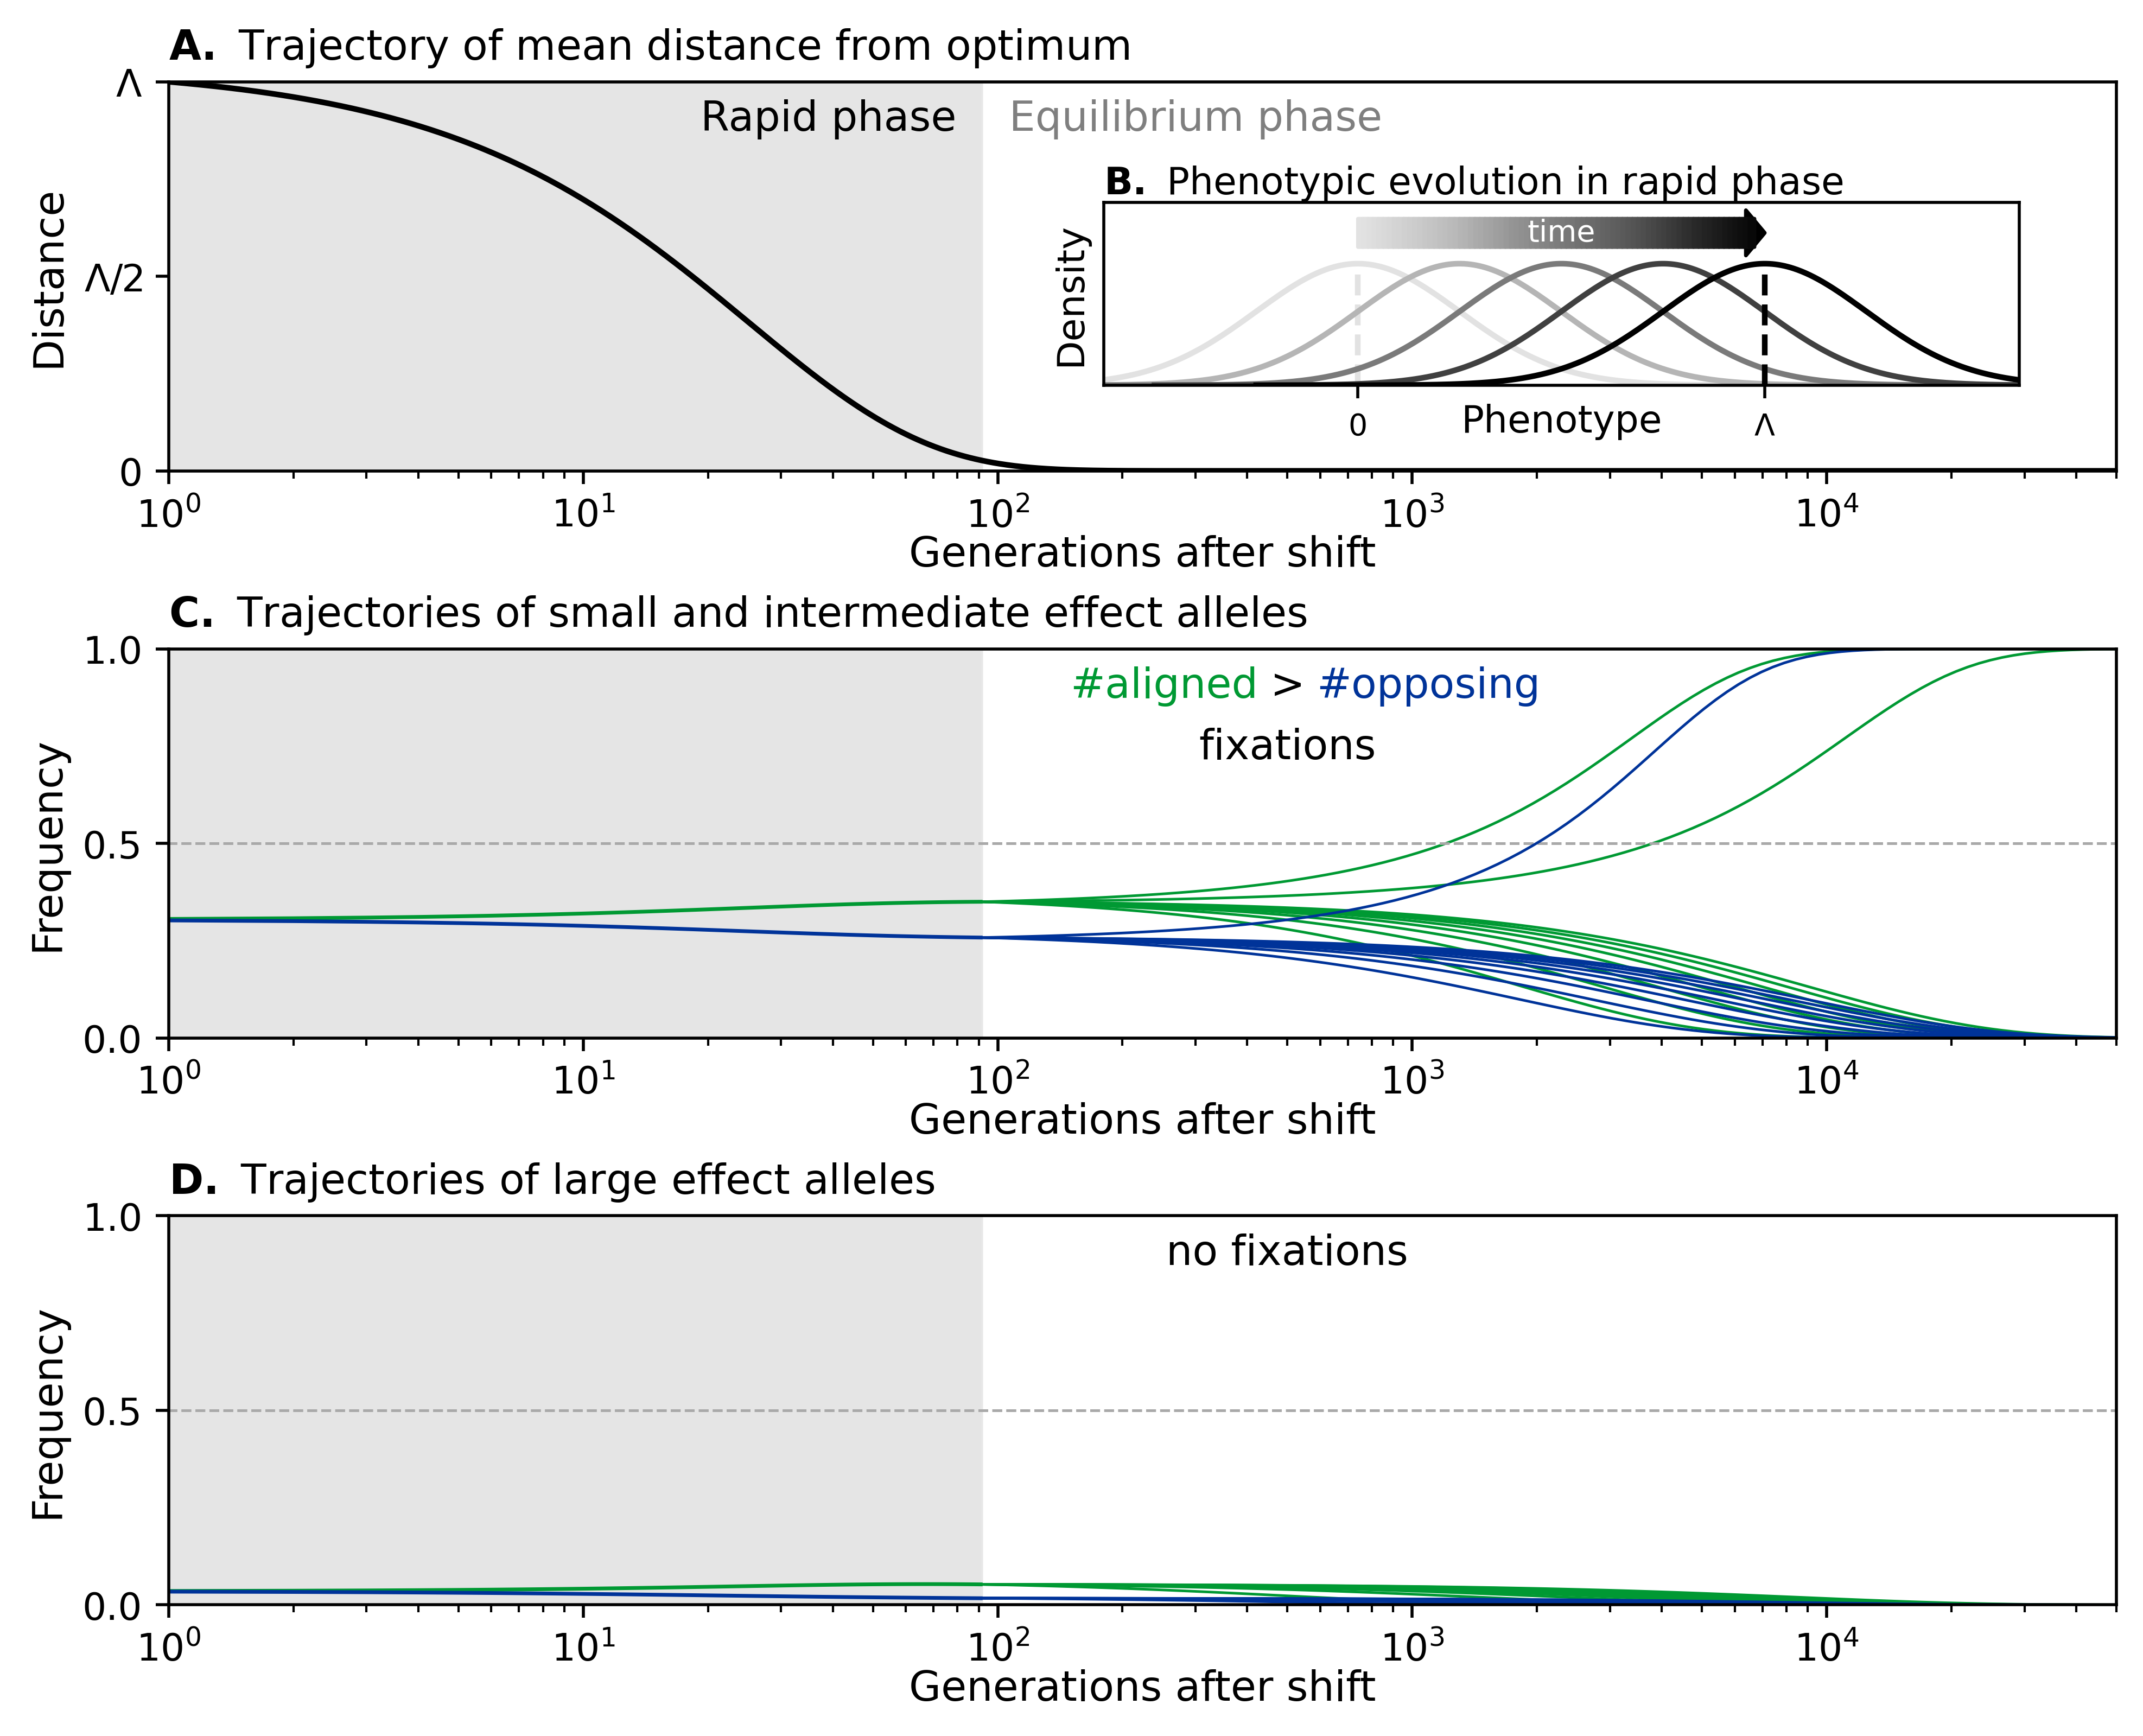

In [3]:
def color_sign(sign):
        if sign == 1:
            color = (0,0.6,0.2)
        else:
            color = (0,0.2,0.6)
        return color

### plot cartoon allelic trajectories
def figure_2_B_and_C(ax,sigma2,shift,S,sign,n_fix,n_extinct):
    
    color = color_sign(sign)
    
    lw = 0.7
    
    ax.plot([0,5e4],[0.5,0.5],ls='--',color='darkgray',lw=lw)
    
    avg_x = ppf_x(S=S,p=0.97)
    a = np.sqrt(S)*sign
    x_traj = [avg_x]
    D = shift
    t_rapid = int(np.log(shift)*2*N/sigma2)
    while len(x_traj) < t_rapid:
        x = x_traj[-1]
        dx = a/(2*N)*x*(1-x)*(D-a*(1/2-x))

        x_traj.append(x+dx)
        D += -sigma2*D/(2*N)-2*a*dx

    x_rapid = x_traj[:t_rapid]
    ax.plot(x_traj[:t_rapid],color=color,lw=1)

    x_star = x_rapid[-1]
    t_values = np.logspace(np.log10(t_rapid),np.log10(5e4),100)-t_rapid

    p_fix = fixation_prob_laura(a = a,x=x_star)
    n_fix = int(10*p_fix)
    n_extinct = 10 - n_fix
    if n_fix == 0:
        flux = 0.9
        t_die = 5e3
    else:
        flux = 0.7
        t_die = 6e3
    for i in range(n_fix):
        realized_flux = i/n_fix*flux*2+1-flux
        x_equilibrium = x_star/(x_star+np.exp(-(t_values)/(t_die*realized_flux))*(1-x_star))
        ax.plot(t_values+t_rapid,x_equilibrium,color=color,lw=lw)
    for i in range(n_extinct):
        realized_flux = i/n_extinct*flux*2+1-flux
        x_equilibrium = x_star*np.exp(-(t_values)/(t_die*realized_flux))
        ax.plot(t_values+t_rapid,x_equilibrium,color=color,lw=lw)
        
    ax.set_xscale('log')
    ax.set_ylabel('Frequency',size=11)
    ax.set_xlabel('Generations after shift',size=11,labelpad=0.1)
    ax.set_ylim([0,1])
    ax.set_yticks([0,0.5,1.0])
    ax.set_xlim([1,5e4])
    
    if sign == 1:
        ax.fill_between([0,t_rapid],[0,0],[1,1],color='k',alpha=0.1,edgecolor=[1,1,1,0])
        
    if n_fix > 0:
        ax.set_title(r'$\bf{C.}$ Trajectories of small and intermediate effect alleles',size=11,loc='left')
    else:
        ax.set_title(r'$\bf{D.}$ Trajectories of large effect alleles',size=11,loc='left')
        
### plot the trajectory of the mean distance from the optimum
def figure_2_A(ax,sigma2,shift):
    times = np.logspace(0,np.log10(5e4),1000)
    distance = shift*np.exp(-(times-1)*sigma2/(2*N))
    ax.plot(times,distance,color='k')
    ax.set_xscale('log')
    ax.set_xlabel('Generations after shift',size=11,labelpad=0.1)
    ax.set_ylabel('Distance',size=11)
    ax.set_xlim([1,5e4])
    ax.set_ylim([0,shift])
    ax.set_ylim
    ax.set_title(r'$\bf{A.}$ Trajectory of mean distance from optimum',size=11,loc='left')
    t_rapid = int(np.log(shift)*2*N/sigma2)
    ax.fill_between([0,t_rapid],[0,0],[shift,shift],color='k',alpha=0.1,edgecolor=[1,1,1,0])
    ax.text(x=t_rapid,y=shift*0.875,s='Rapid phase  ',horizontalalignment='right',color='k',size=11)
    ax.text(x=t_rapid,y=shift*0.875,s='  Equilibrium phase',horizontalalignment='left',color=[0,0,0,0.5],size=11)
    ax.set_yticks([0,shift/2,shift])
    ax.set_yticklabels(['0',r'$\Lambda / 2$',r'$\Lambda$'])

### functions for plotting the inset panel
def plot_normal_distribution(VA,mean,color,ax):
    x = np.linspace(-100,100,1000)
    y = stats.norm.pdf(x+mean,loc=mean,scale=np.sqrt(VA))
    ax.plot(x+mean,y,color=color)

def make_highly_polygenic_phenotypic_evolution(ax,VA=400,shift=80,fontsize=10):
    cmap = mpl.cm.get_cmap('Greys')
    std = np.sqrt(VA)
    for mean in np.linspace(0,shift,5):
        plot_normal_distribution(VA=VA,mean=mean,color=cmap(mean/shift*0.8+0.2),ax=ax)
        if mean == 0 or mean == shift:
            max_y = stats.norm.pdf(mean,loc=mean,scale=std)
            ax.plot([mean,mean],[0,max_y],color=cmap(mean/shift*0.8+0.2),ls='--')
    ax.set_xlabel('Phenotype',size=fontsize,labelpad=-10)
    ax.set_ylabel('Density',size=fontsize)
    ax.set_title(r'$\bf{B.}$ Phenotypic evolution in rapid phase',size=fontsize,loc='left',pad=0)
    ax.set_ylim([0,0.03])
    ax.set_xlim([-std*2.5,shift+std*2.5])
    ax.set_xticks([0,shift])
    ax.set_xticklabels(['0',r'$\Lambda$'])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(8)
    arrow_height = 0.025
    ax.annotate('',
                xy=(shift, arrow_height), xycoords='data',
                xytext=(10,arrow_height), textcoords='data',
                arrowprops=dict(facecolor='black', shrink=0.0,headlength=5),
                horizontalalignment='center', verticalalignment='bottom')
    for i in range(shift-2):
        ax.annotate('',
                xy=(i+1, arrow_height), xycoords='data',
                xytext=(i,arrow_height), textcoords='data',
                arrowprops=dict(facecolor=cmap(i/shift*0.8+0.2), width=7.5, shrink=0.02,headlength=0.01,headwidth=1,edgecolor=cmap(i/shift*0.8+0.2)),
                horizontalalignment='center', verticalalignment='bottom')

    ax.text(x=shift/2,y=arrow_height,s=r'time',horizontalalignment='center',verticalalignment='center',size=8,color='white')
    ax.set_yticks([])

def make_figure_2_1():
    fig, axes = plt.subplot_mosaic("AAA;BBB;CCC",dpi=500,figsize=(8,6.5))

    sigma2 = 400
    shift = np.sqrt(sigma2)*2
    figure_2_B_and_C(ax=axes['B'],sigma2=sigma2,shift=shift,S=5,sign=1,n_fix=5,n_extinct=5)
    figure_2_B_and_C(ax=axes['B'],sigma2=sigma2,shift=shift,S=5,sign=-1,n_fix=3,n_extinct=5)
    figure_2_B_and_C(ax=axes['C'],sigma2=sigma2,shift=shift,S=35,sign=1,n_fix=0,n_extinct=5)
    figure_2_B_and_C(ax=axes['C'],sigma2=sigma2,shift=shift,S=35,sign=-1,n_fix=0,n_extinct=5)
    figure_2_A(ax=axes['A'],sigma2=sigma2,shift=shift)
    plt.subplots_adjust(wspace=0.,hspace=0.55)

    axins = axes['A'].inset_axes(
        [0.48, 0.22, 0.47, 0.47], xticklabels=[], yticklabels=[])
    make_highly_polygenic_phenotypic_evolution(ax=axins,VA=400,shift=80)

    text_height=0.875
    B_equal = axes['B'].text(x=500,y=text_height,s='>',horizontalalignment='center',size=11,color='k')
    r = fig.canvas.get_renderer()
    bb = B_equal.get_window_extent(renderer=r)
    inv = axes['B'].transData.inverted()
    ## get the x and y in data coordinates
    x_min,y_min = inv.transform(bb.corners()[0])
    x_max,y_max = inv.transform(bb.corners()[2])

    axes['B'].text(x=x_min*0.95,y=text_height,s='#aligned',horizontalalignment='right',size=11,color=color_sign(1))
    axes['B'].text(x=x_max/0.95,y=text_height,s='#opposing',horizontalalignment='left',size=11,color=color_sign(-1))
    axes['B'].text(x=500,y=y_min-0.05,s='fixations',horizontalalignment='center',verticalalignment='top',size=11,color='k')

    axes['C'].text(x=500,y=text_height,s='no fixations',horizontalalignment='center',size=11,color='k')
    # raise ValueError
    plt.tight_layout(h_pad=0.5)
    plt.savefig('/Users/will_milligan/Desktop/sella/figure_2_1.png',bbox_inches='tight',dpi=400)

make_figure_2_1()


###Make Figure 1###

0.15000000000000002
0.355
0.56
0.765
0.9700000000000001


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


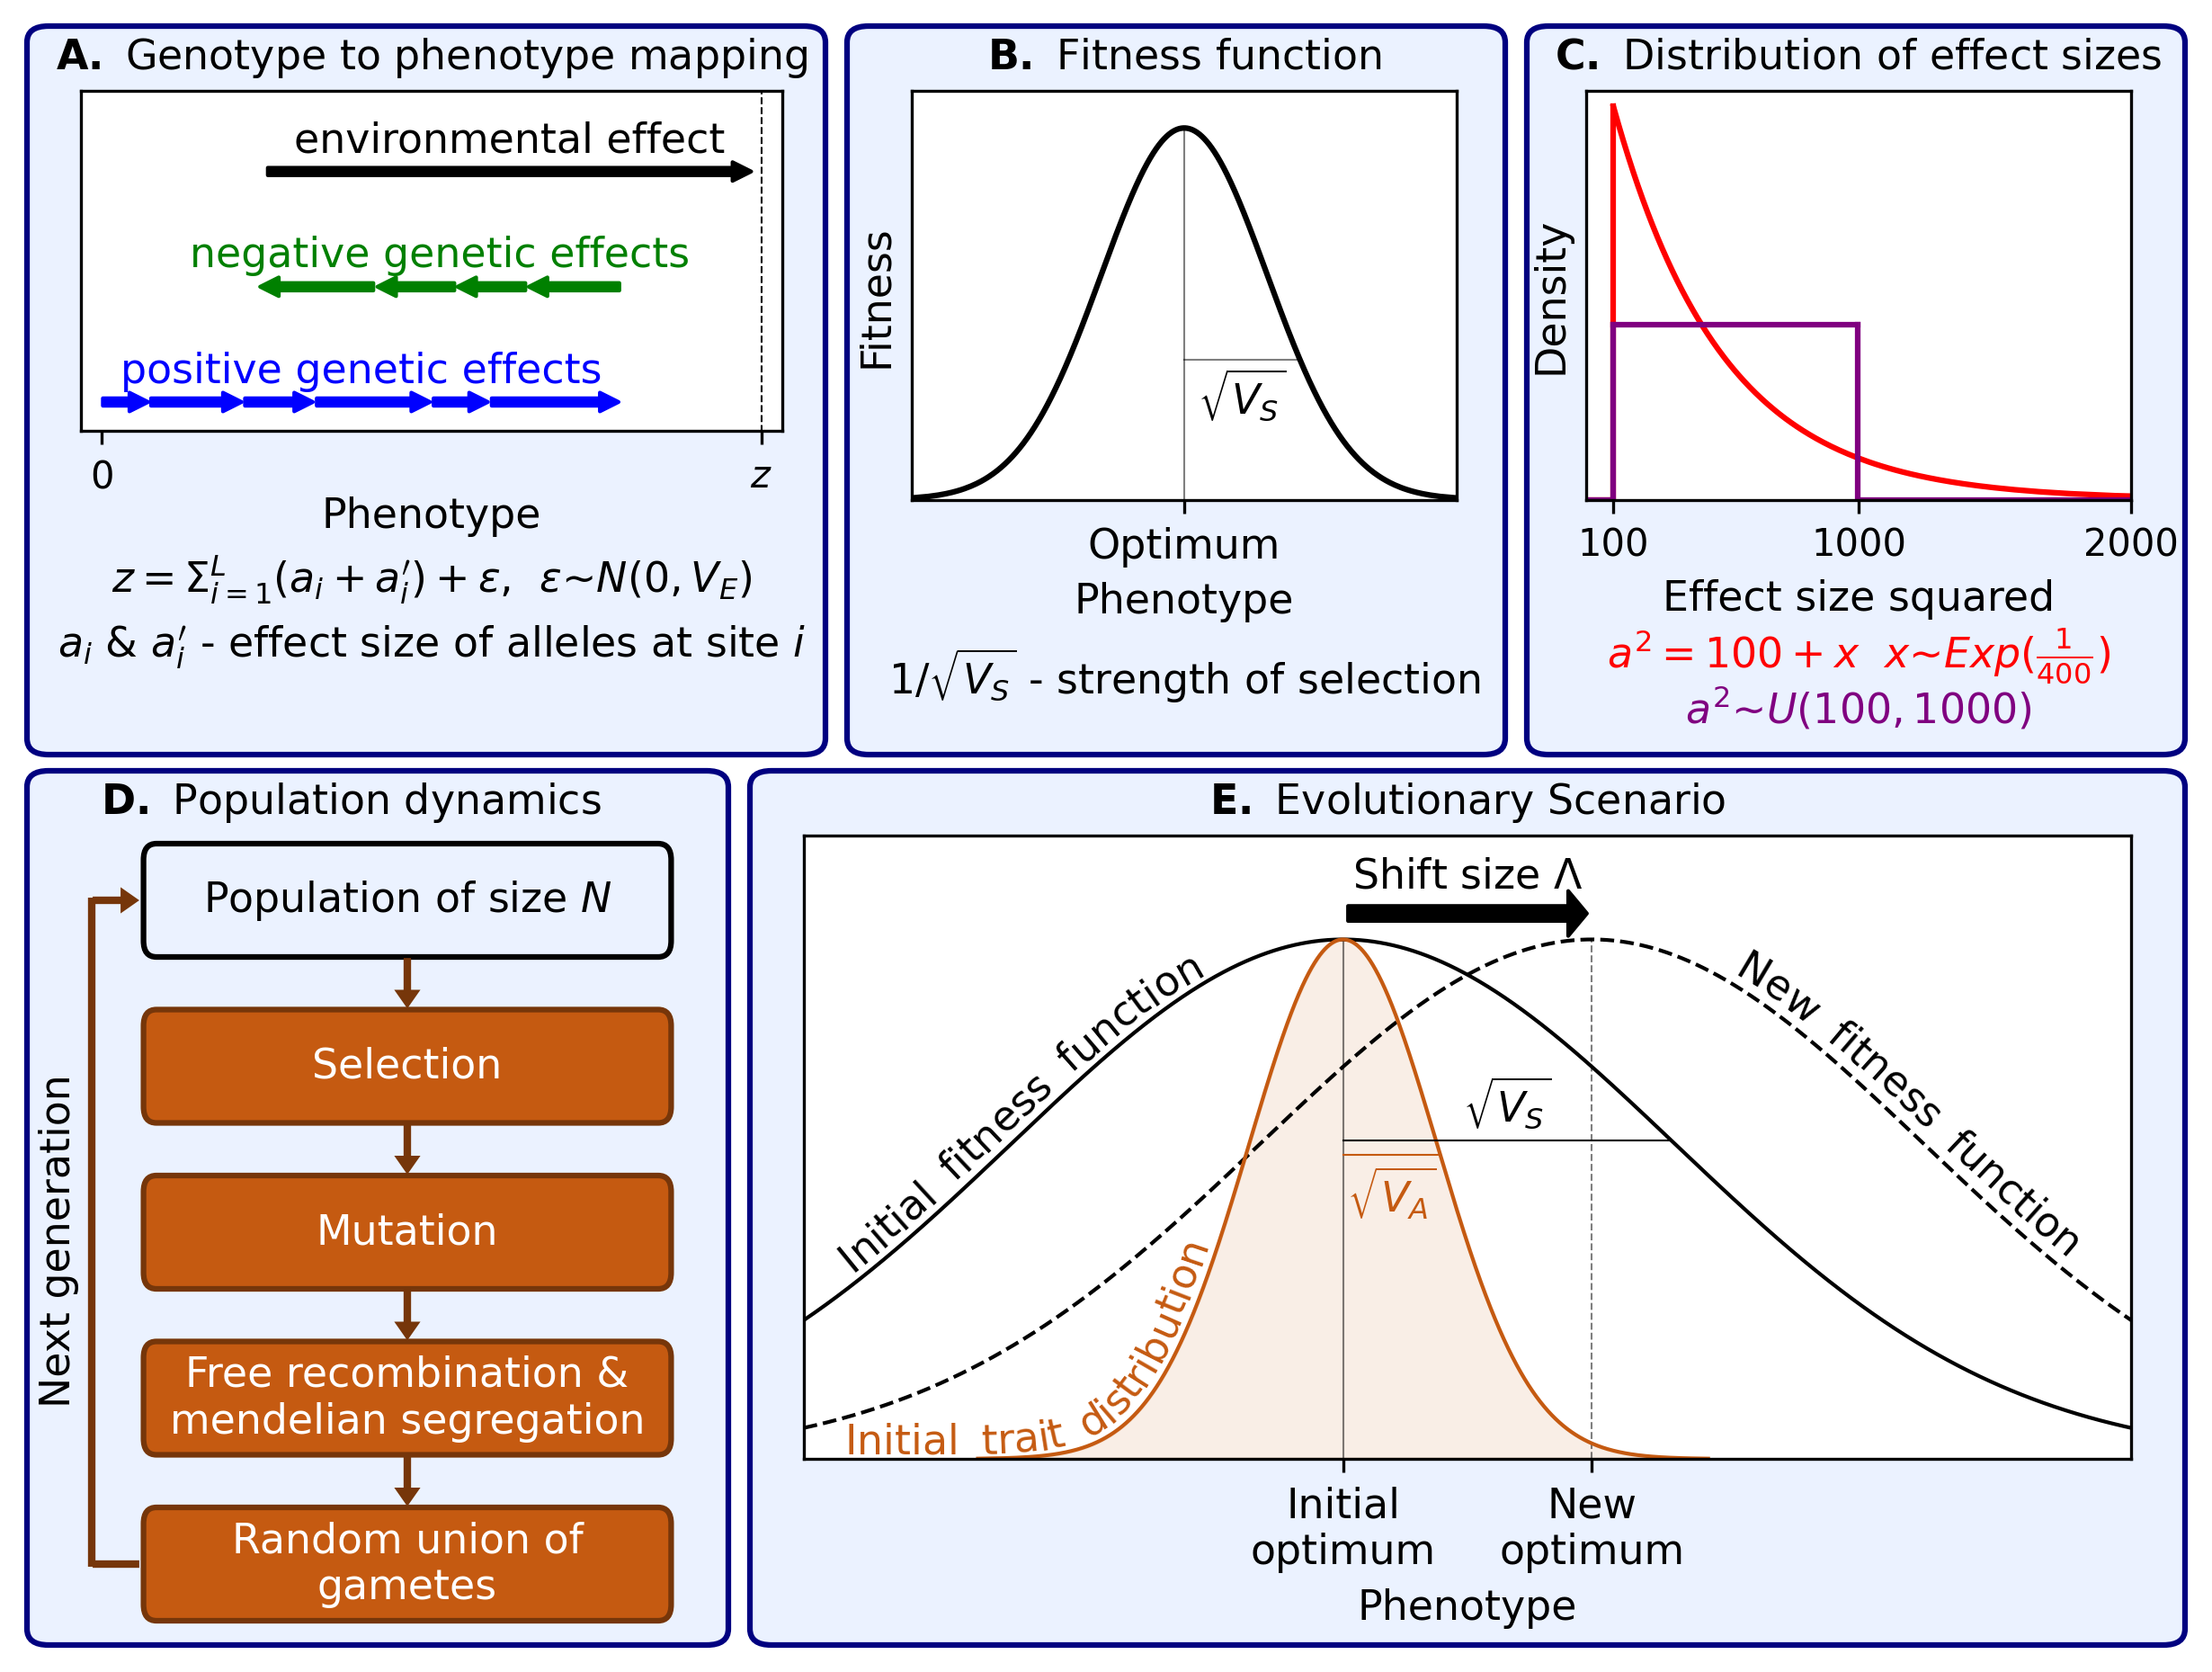

In [ ]:
# plot effect size distribution
def plot_effect_size_distribution(sdist,color,ax):
    z_values = np.linspace(0,1,200)[:-1]
    x_values = sdist.ppf(z_values)
    y_values = sdist.pdf(x_values)
    ax.plot(x_values,y_values,color=color)
    ax.plot([0,100,100],[0,0,y_values[0]],color=color,ls='-')
    ax.plot([x_values[-1],x_values[-1],10000],[y_values[-1],0,0],color=color,ls='-')


def make_figure_1_C(ax):
    sdist = stats.expon(scale=400,loc=100)
    plot_effect_size_distribution(sdist=sdist,color='r',ax=ax)
    sdist = stats.uniform(100,900)
    plot_effect_size_distribution(sdist=sdist,color='purple',ax=ax)
    ax.set_xlabel('Effect size squared',size=11)
    ax.set_ylabel('Density',size=11)
    ax.set_title(r'$\bf{C.}$ Distribution of effect sizes',size=11)
    ax.set_xlim([0,2000])
    ax.set_xticks([100,1000,2000])
    ax.set_ylim([0,0.0026])
    ax.set_yticks([])
    # Get the bounding box of the axes
    bbox = ax.get_window_extent()

# plot fitness function
def plot_fitness_function(N,ax):
    fitness_dist = stats.norm(loc=0,scale=(2*N)**(0.5))
    z_values = np.linspace(0,1,2000)[1:-1]
    x_values = fitness_dist.ppf(z_values)
    y_values = fitness_dist.pdf(x_values)
    ax.plot(x_values,y_values,color='k')
    
    fitness_width = np.sqrt(2*N)*1.4
    ax.plot([0,fitness_width],[fitness_dist.pdf(fitness_width)]*2,color='k',ls='-',lw=0.5,alpha=0.5)
    ax.plot([0,0],[0,fitness_dist.pdf(0)],color='k',ls='-',lw=0.5,alpha=0.5)
    ax.text(x=fitness_width/2,y=fitness_dist.pdf(fitness_width)/1.05,s=r'$\sqrt{V_S}$',horizontalalignment='center',verticalalignment='top',size=11,color='k',alpha=1)
    ax.set_xlabel('Phenotype',size=11)
    ax.set_ylabel('Fitness',size=11)
    ax.set_title(r'$\bf{B.}$ Fitness function',size=11)
    ax.set_xticks([0])
    ax.set_yticks([])
    ax.set_xticklabels(['Optimum'])
    ## set x tick label font size to be 11
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(11)
    ax.set_xlim([min(x_values),max(x_values)])
    ax.set_ylim([0,max(y_values)*1.1])
    # ax.set_xlim([0,1])
    

def make_figure_1_B(ax):
    plot_fitness_function(N=5000,ax=ax)

def plot_genotype_to_phenotype_mapping(ax):
    mu = 0
    aligned_effects = [10,20,15,25,12,28]
    aligned_effects = np.array(aligned_effects)*2.25
    opposing_effects = [-20,-15,-17,-25]
    opposing_effects = np.array(opposing_effects)*2.25
    current_position = 0
    for effect in aligned_effects:
        current_position += effect
        ax.annotate('',
            xy=(current_position, 0), xycoords='data',
            xytext=(current_position-effect, 0), textcoords='data',
            arrowprops=dict(facecolor='blue', shrink=0.02,edgecolor='blue',headlength=5,headwidth=5,width=2),
            horizontalalignment='center', verticalalignment='bottom')
    for effect in opposing_effects:
        # plot an arrow
        current_position += effect
        ax.annotate('',
            xy=(current_position, 1), xycoords='data',
            xytext=(current_position-effect, 1), textcoords='data',
            arrowprops=dict(facecolor='green', shrink=0.02,edgecolor='green',headlength=5,headwidth=5,width=2),
            horizontalalignment='center', verticalalignment='bottom')
        # ax.arrow(current_position,1,effect+head_length+5,0,head_width=head_width, head_length=head_length, fc='green', ec='green',lw=5)

        
    # ax.arrow(current_position,2,50,0,head_width=head_width, head_length=head_length, fc='k', ec='k')
    environmental_effect = 240
    current_position += environmental_effect
    ax.annotate('',
            xy=(current_position, 2), xycoords='data',
            xytext=(current_position-environmental_effect, 2), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.02,headlength=5,headwidth=5,width=2),
            horizontalalignment='center', verticalalignment='bottom')
    ax.set_yticks([])
    ax.set_ylim([-0.25,2.7])
    ax.set_xticks([mu,current_position])
    ax.set_xticklabels([r'$0$',r'$z$'])
    ax.set_xlim([-10,current_position+10])
    ax.set_xlabel('Phenotype',size=11,labelpad=0.1)
    ax.text(x = current_position - environmental_effect/2,y=2.175,s='environmental effect',horizontalalignment='center',size=11)
    ax.text(x = (current_position - environmental_effect) - sum(opposing_effects)/2,y=1.175,s='negative genetic effects',horizontalalignment='center',size=11,color='green')
    ax.text(x = sum(aligned_effects)/2,y=0.175,s='positive genetic effects',horizontalalignment='center',size=11,color='blue')
    ax.plot([current_position,current_position],[-10,20],color='k',ls='--',lw=0.5)

def make_figure_1_A(ax):
    plot_genotype_to_phenotype_mapping(ax=ax)
    ax.set_title(r'$\bf{A.}$ Genotype to phenotype mapping',size=11)

def plot_normal_distribution(N,mean,color,ax,ls='-',fill=False,label_x = 0, label = '',label_name = '',label_name_x = 0,fontsize=11,lw=1,annotation_lw=0.5):
    
    normdist = stats.norm(loc=mean,scale=np.sqrt(2*N))
    z = np.linspace(0,1,20000)
    x = normdist.ppf(z)
    y = normdist.pdf(x)/normdist.pdf(mean)
    ax.plot(x,y,color=color,ls=ls,lw=lw)
    text_width = normdist.std()
    if not fill:
        ax.plot([mean,mean],[0,1],color=color,ls=ls,lw=annotation_lw,alpha=1)
    else:
        ax.fill_between(x,y,0,color=color,alpha=0.1)
    if label:
        if label == r'$\sqrt{V_S}$':
            text_width -= 1
            y_label = normdist.pdf(text_width)/normdist.pdf(mean)
            y_label_adjust = 0.02
            verticalalignment = 'bottom'
        else:
            text_width += 1
            y_label = normdist.pdf(text_width)/normdist.pdf(mean)
            y_label_adjust = -0.02
            verticalalignment = 'top'
        ax.plot([0,text_width],[y_label]*2,color=color,ls=ls,zorder=100,lw=annotation_lw)
        # ax.text(x=text_width/2*0.9,y=y_label+y_label_adjust,s=label,horizontalalignment='center',size=11,color=color,verticalalignment=verticalalignment)
        ax.text(x=text_width/2,y=y_label+y_label_adjust,s=label,horizontalalignment='center',size=fontsize,color=color,verticalalignment=verticalalignment)
    
    if label_name:
        if label_name_x == 0:
            label_name_x = -130
        x_label = np.linspace(label_name_x,250,1000)
        y_label = normdist.pdf(x_label)/normdist.pdf(mean)
        if label_name == 'Initial fitness function':
            x_label = x_label - 5
        elif label_name == 'New fitness function':
            x_label = x_label + 5
        else:
            y_label = y_label + 0.01
            x_label = x_label - 3
        g=CurvedText(x=x_label,y=y_label,text=label_name,axes=ax,fontsize=fontsize,color=color)
    

def make_figure_1_E(ax,fontsize=11,lw=1,annotation_lw=0.5):
    shift = 75
    plot_normal_distribution(N=5000,mean=0,color='k',ax=ax,label_x=100,label=r'$\sqrt{V_S}$',label_name='Initial fitness function',label_name_x=-145,fontsize=fontsize,lw=lw,annotation_lw=annotation_lw)
    plot_normal_distribution(N=5000,mean=shift,color='k',ls='--',ax=ax,label_name = 'New fitness function',label_name_x=110,fontsize=fontsize,lw=lw,annotation_lw=annotation_lw)
    plot_normal_distribution(N=800/2,mean=0,color=[0.773,0.353,0.067],ls='-',ax=ax,fill=True,label_x=40,label=r'$\sqrt{V_A}$',label_name = 'Initial trait distribution',label_name_x=-150,fontsize=fontsize,lw=lw,annotation_lw=annotation_lw)
    ax.set_xlabel('Phenotype',size=11)
    width = 200
    ax.set_xlim([shift/2-width,shift/2+width])
    ax.set_xticks([0,shift])
    ax.set_xticklabels(['Initial\noptimum','New\noptimum'])
    ## set x tick label font size to be 11
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(11)
    ax.annotate('',
                xy=(shift, 1.05), xycoords='data',
                xytext=(0, 1.05), textcoords='data',
                arrowprops=dict(facecolor='k', shrink=0.02,edgecolor='k',headlength=5),
                horizontalalignment='center', verticalalignment='bottom')
    ax.set_ylim([0,1.2])
    ax.set_yticks([])
    ax.text(x=shift/2,y=1.1,s='Shift size ' + r'$\Lambda$',horizontalalignment='center',size=fontsize)
    ax.set_title(r'$\bf{E.}$ Evolutionary Scenario',size=11)

def make_figure_1_D(ax):
    ax.set_title(r'$\bf{D.}$ Population dynamics',size=11)
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    
    rect_height_total = 0.5
    rect_height = rect_height_total/5
    distance_between_rects = (0.92-rect_height_total)/4
    rectangles={}
    color=[0.773,0.353,0.067]
    edge_color_save = [jj*0.6 for jj in color]

    for i in range(5):
        min_y=0.05+(rect_height+distance_between_rects)*i
        max_y=min_y+rect_height
        min_x=0.2
        max_x=min_x+0.775
        print(max_y)
        
        if i == 4:
            face_color = [1,1,1,0]
            edge_color = 'k'
        else:
            face_color = color
            edge_color = edge_color_save
        rect = FancyBboxPatch((min_x,min_y),max_x-min_x,max_y-min_y,boxstyle="round,pad=0.02",ec=edge_color,fc=face_color,mutation_aspect=1,lw=1.5)
        

        if i == 4:
            ax.text(x=(min_x+max_x)/2,y=(min_y+max_y)/2,s=r'Population of size $N$',horizontalalignment='center',verticalalignment='center',size=11,color='k')
        elif i == 3:
            ax.text(x=(min_x+max_x)/2,y=(min_y+max_y)/2,s=r'Selection',horizontalalignment='center',verticalalignment='center',size=11,color='white')
        elif i == 2:
            ax.text(x=(min_x+max_x)/2,y=(min_y+max_y)/2,s=r'Mutation',horizontalalignment='center',verticalalignment='center',size=11,color='white')
        elif i == 1:
            ax.text(x=(min_x+max_x)/2,y=(min_y+max_y)/2,s='Free recombination &\nmendelian segregation',horizontalalignment='center',verticalalignment='center',size=11,color='white')
        elif i == 0:
            ax.text(x=(min_x+max_x)/2,y=(min_y+max_y)/2,s='Random union of\ngametes',horizontalalignment='center',verticalalignment='center',size=11,color='white')
        ax.add_patch(rect)
        rectangles[i] = (min_x,max_x,min_y,max_y)
        
    for i,j in [(4,3),(3,2),(2,1),(1,0)]:
        min_x,max_x,min_y,max_y = rectangles[i]
        min_x2,max_x2,min_y2,max_y2 = rectangles[j]
        mid_x = (min_x+max_x)/2
        headlength = 0.02
        ax.annotate('',
                xy=(mid_x, max_y2+headlength), xycoords='data',
                xytext=(mid_x, min_y-headlength), textcoords='data',
                arrowprops=dict(facecolor=edge_color_save,edgecolor='None', shrink=0.02,headlength=5,headwidth=7,width=2),
                horizontalalignment='center', verticalalignment='center')
        
    rect_top = rectangles[4]
    rect_bottom = rectangles[0]
    min_x,max_x,min_y,max_y = rect_top
    min_x2,max_x2,min_y2,max_y2 = rect_bottom
    mid_y = (min_y+max_y)/2
    mid_y2 = (min_y2+max_y2)/2
    ax.annotate('',
        xy=(0.175, mid_y), xycoords='data',
        xytext=(0.1, mid_y), textcoords='data',
        arrowprops=dict(facecolor=edge_color_save, edgecolor='None',shrink=0.02,headlength=5,headwidth=7,width=2),
        horizontalalignment='center', verticalalignment='center')
    ax.annotate('',
        xy=(0.1, mid_y+0.0205), xycoords='data',
        xytext=(0.1, mid_y2-0.0205), textcoords='data',
        arrowprops=dict(facecolor=edge_color_save, edgecolor='None',shrink=0.02,headlength=0.0001,headwidth=0.0001,width=2),
        horizontalalignment='center', verticalalignment='center')
    ax.annotate('',
        xy=(0.175, mid_y2), xycoords='data',
        xytext=(0.1, mid_y2), textcoords='data',
        arrowprops=dict(facecolor=edge_color_save, edgecolor='None',shrink=0.02,headlength=0.0001,headwidth=0.0001,width=2),
        horizontalalignment='center', verticalalignment='center')
    ax.text(x=0.05,y=0.5,s=r'Next generation',horizontalalignment='center',verticalalignment='center',size=11,rotation=90)
    

def make_figure_1(fig_width=8,fig_height=8):
    
    fig = plt.figure(dpi=300,figsize=(8,6))
    y_scaling = fig_height/fig_width
    
    b_width = 0.25
    b_height = b_width*fig_width/fig_height

    a_min_x = 0.025
    a_max_x = 0.35
    a_max_y = 0.96
    a_min_y = 0.75
    a_y = a_min_y
    a_x = a_min_x
    a_width = a_max_x-a_min_x
    a_height = a_max_y-a_min_y
    
    pad_between_axes = 0.06
    b_x = a_max_x+pad_between_axes
    b_width = (1-0.025-b_x-pad_between_axes)/2
    b_height = b_width*y_scaling
    b_y = 0.96-b_height
    
    c_x = 1-0.025-b_width
    c_width = b_width
    c_height = b_height
    c_y = b_y
    
    a = fig.add_axes(rect=[a_x,a_y,a_width,a_height])
    b = fig.add_axes(rect=[b_x,b_y,b_width,b_height])
    c = fig.add_axes(rect=[c_x,c_y,c_width,c_height])
    
    d_top = 0.5
    d_height = 0.5
    d_x = 0
    d_width = 0.3
    d_y = d_top-d_height
    
    e_x = d_x+d_width+pad_between_axes
    e_width = 1-e_x-0.025
    e_top = d_top
    e_bottom = 0.115
    e_height = e_top-e_bottom
    e_y = e_bottom
    # a=fig.add_axes(rect=[0+pad,0.75+pad,0.4-pad,0.25-pad])
    
    # b=fig.add_axes(rect=[0.4+pad,0.7+pad,0.3-pad,0.3-pad])
    # c=fig.add_axes(rect=[0.7+pad,0.7+pad,0.3-pad,0.3-pad])
    d=fig.add_axes(rect=[d_x,d_y,d_width,d_height])
    e=fig.add_axes(rect=[e_x,e_y,e_width,e_height])
   
    make_figure_1_A(a)
    make_figure_1_B(b)
    make_figure_1_C(c)
    make_figure_1_E(e)
    make_figure_1_D(d)
    
    fig.text(x=(a_min_x+a_max_x)/2,y=0.65,s=r'$z=\Sigma_{i=1}^{L}(a_i+a^{\prime}_i)+\epsilon$,  $\epsilon$~$N(0,V_E)$',horizontalalignment='center',size=11)
    fig.text(x=(a_min_x+a_max_x)/2,y=0.61,s=r'$a_i$ & $a^{\prime}_i$ - effect size of alleles at site $i$',horizontalalignment='center',size=11)
    # fig.text(x=(a_min_x+a_max_x)/2,y=0.57,s=r'$\mu=$ phenotype of fixed background',horizontalalignment='center',size=11)
    fig.text(x=b_x+b_width/2,y=0.5875,s=r'$1/\sqrt{V_S}$ - strength of selection',horizontalalignment='center',size=11)
    fig.text(x=c_x+c_width/2,y=0.605,s=r'$a^2=100+x$  $x$~$Exp(\frac{1}{400})$',horizontalalignment='center',size=11,clip_on=False,color='r')
    fig.text(x=c_x+c_width/2,y=0.57,s=r'$a^2$~$U(100,1000)$',horizontalalignment='center',size=11,clip_on=False,color='purple')
    plt.tight_layout(h_pad=0,w_pad=0)
    # plt.savefig('/Users/will_milligan/Desktop/sella/figure_1.png',bbox_inches='tight',dpi=400)
    
    facecolor = [0.92,0.95,1]
    edgecolor = 'navy'
    #
    row_1_y = d_top+0.05
    row_1_height = 1-row_1_y
    row_2_y = 0
    row_2_height = row_1_y-0.01
    fig.patches.extend([FancyBboxPatch((0,row_1_y),a_width+a_x+0.02,row_1_height, boxstyle='Round, pad=0,rounding_size=0.01', mutation_aspect=1,facecolor=facecolor,edgecolor=edgecolor,clip_on=False,lw=1.5,transform=fig.transFigure, figure=fig,zorder=-1)])
    fig.patches.extend([FancyBboxPatch((a_width+a_x+0.03,row_1_y),(1-(a_width+a_x+0.03)-0.01)/2,row_1_height, boxstyle='Round, pad=0,rounding_size=0.01', mutation_aspect=1,facecolor=facecolor,edgecolor=edgecolor,clip_on=False,zorder=-1,lw=1.5,transform=fig.transFigure, figure=fig)])
    fig.patches.extend([FancyBboxPatch((a_width+a_x+0.03+(1-(a_width+a_x+0.03)-0.01)/2+0.01,row_1_y),(1-(a_width+a_x+0.03)-0.01)/2,row_1_height, boxstyle='Round, pad=0,rounding_size=0.01', mutation_aspect=1,facecolor=facecolor,edgecolor=edgecolor,clip_on=False,zorder=-1,lw=1.5,transform=fig.transFigure, figure=fig)])
    # fig.patches.extend([FancyBboxPatch((0,0),1,1, boxstyle='Round, pad=0,rounding_size=0.01', mutation_aspect=1,facecolor=[1,0,0,0.1],edgecolor=edgecolor,clip_on=False,zorder=-1,lw=1.5,transform=fig.transFigure, figure=fig)])
    fig.patches.extend([FancyBboxPatch((0,row_2_y),((d_x+d_width)+e_x)/2-0.005,row_2_height, boxstyle='Round, pad=0,rounding_size=0.01', mutation_aspect=1,facecolor=facecolor,edgecolor=edgecolor,clip_on=False,zorder=-1,lw=1.5,transform=fig.transFigure, figure=fig)])
    fig.patches.extend([FancyBboxPatch((((d_x+d_width)+e_x)/2+0.005,row_2_y),1-(((d_x+d_width)+e_x)/2+0.005),row_2_height, boxstyle='Round, pad=0,rounding_size=0.01', mutation_aspect=1,facecolor=facecolor,edgecolor=edgecolor,clip_on=False,zorder=-1,lw=1.5,transform=fig.transFigure, figure=fig)])
    plt.savefig('/Users/will_milligan/Desktop/sella/ShortPaper_Figure_1.png',bbox_inches='tight',dpi=300)

make_figure_1()



In [5]:
# generate random trajectories for figure 3
def random_recursion(a,x,shift,sigma2,N=5000):
    x_store = [x]
    D_traj = [shift]
    D = shift
    while x < 1 and x > 0:
        dx = a*x*(1-x)*(D_traj[-1]-a*(1/2-x))/(2*N)
        deterministic_x =  min(1,max(0,x + dx))
        realized_x = np.random.binomial(2*N,deterministic_x)/(2*N)
        D += - 2*a*(realized_x-x)-sigma2*D_traj[-1]/(2*N)
        x = realized_x
        x_store.append(x)
        D_traj.append(D)
    useful_length = len(x_store)
    while D > 0.1:
        D += -sigma2*D/(2*N)
        x_store.append(x)
        D_traj.append(D)
    return x_store,D_traj,useful_length

# generate deterministic trajectories for figure 3
def deterministic_recursion(a,x,shift,sigma2,N=5000):
    x_store = [x]
    D_traj = [shift]
    D = shift
    while ((x < 1-1e-4 and x > 1e-4) or (D > 0.001)):
        
        dx = a*x*(1-x)*(D_traj[-1]-a*(1/2-x))/(2*N)
        deterministic_x = min(1,max(0,x + dx))
        D += - 2*a*(deterministic_x-x)-sigma2*D_traj[-1]/(2*N)
        x = deterministic_x
        x_store.append(x)
        D_traj.append(D)
    
    return x_store,D_traj

# plot deterministic and random trajectories for figure 3
def plot_deterministic_trajectories(ax_x,ax_d,a,x,shifts,colors,sigma2,ax_x_inset):
    for (DD,(shift,idx)),color in zip(shifts.items(),colors):
        null = [np.nan]*idx
        x_store,D_traj = deterministic_recursion(a=a,x=x,shift=shift,N=N,sigma2=sigma2)
        D_traj = np.array(null+D_traj)/DD
        ax_x.plot(null+x_store,color=color,ls='--')
        ax_d.plot(D_traj,color=color,ls='--')
        
    
def plot_random_trajectories(ax_x,ax_d,a,x,shifts,colors,outcomes,outcome_lengths,sigma2,ax_x_inset):
    deterministic_starts = {}
    for shift,color,outcome,(length_min,length_max) in zip(shifts,colors,outcomes,outcome_lengths):
        if shift == 100:
            np.random.seed(1)
        else:
            np.random.seed(31)
        x_store,D_traj,useful_length = random_recursion(a=a,x=x,shift=shift,N=N,sigma2=sigma2)
        while x_store[-1] != outcome or useful_length>length_max or useful_length<length_min:
            x_store,D_traj,useful_length = random_recursion(a=a,x=x,shift=shift,N=N,sigma2=sigma2)
        D_traj = np.array(D_traj)/np.max(D_traj)
        ax_x.plot(x_store,color=color)
        ax_x_inset.plot(x_store,color=color)
        if useful_length > 200:
            ax_d.plot(D_traj,color=color)
        
        if length_max > 200:
        # find where x_store > 1/200
            x_store = np.array(x_store)
            idx = np.where(x_store > 1/100)[0]
            D_idx = D_traj[idx[0]]*shift
            deterministic_starts[shift]=(D_idx,idx[0])
    return deterministic_starts
    
# make figure 3 A and B panels
def make_figure_3_left_side(ax_x,ax_d):
    internal_inset_fontsize = 11
    external_inset_fontsize = 11
    ### add a zoomed inset for ax_x
    axins = ax_x.inset_axes(
        [0.68, 0.25, 0.3, 0.57],
        xlim=(0, 40), ylim=(0, 1/100), xticklabels=[], yticklabels=[],zorder=1)
    axins.set_xticks([0,40])
    axins.set_yticks([0,1/100])
    axins.set_xticklabels(['0',r'40'],size=external_inset_fontsize)
    axins.set_yticklabels(['0',r'0.01'],size=external_inset_fontsize)
    axins.set_xlabel('Generations after shift',size=external_inset_fontsize,labelpad=-10)
    axins.set_ylabel('Frequency',size=external_inset_fontsize,labelpad=1)
    axins.set_title(r'$\bf{C.}$ Establishment or loss',size=external_inset_fontsize,pad=-1,loc='left')
    # axins.imshow(Z2, extent=extent, origin="lower")

    trash,(ll,ul,lr,ur) = ax_x.indicate_inset_zoom(axins, edgecolor=[0.85]*3)
    lr.set_visible(False)
    ur.set_visible(False)
    ll.set_visible(False)
    ul.set_visible(False)
    ul.set_zorder(-1)
    lr.set_zorder(-1)


    establish_fix_color = 'goldenrod'
    # get rgba of a named color
    establish_fix_rgba = list(mpl.colors.to_rgba(establish_fix_color))
    establish_fix_rgba = [(i+1)/2 for i in establish_fix_rgba]
    establish_fix_rgba[-1] = 1
    establish_extinct_rgba = list(mpl.colors.to_rgba('purple'))
    establish_extinct_rgba = [(i+1)/2 for i in establish_extinct_rgba]
    establish_extinct_rgba[-1] = 1
    extinct_color = 'k'
    extinct_rgba = list(mpl.colors.to_rgba(extinct_color))
    extinct_rgba[-1] = 1

    #

    np.random.seed(14)
    S = 200
    a = 200**(0.5)
    x = 1/(200*2)
    sigma2 = 80
    shift_big = 100
    shift_small = 50
    deterministic_starts = plot_random_trajectories(ax_x=ax_x,ax_d=ax_d,ax_x_inset = axins,a=a,x=x,shifts=[shift_big,shift_small,shift_big],colors=[establish_fix_rgba,establish_extinct_rgba,extinct_rgba],outcomes=[1,0,0],outcome_lengths=[(0,np.inf),(70,np.inf),(0,100)],sigma2=sigma2)

    plot_deterministic_trajectories(ax_x=ax_x,ax_d=ax_d,ax_x_inset = axins,a=a,x=1/100,shifts=deterministic_starts,colors=[establish_fix_rgba,establish_extinct_rgba],sigma2=sigma2)
    # plot_random_trajectories(ax_x=ax_x,ax_d=ax_d,a=a,x=x,shifts=[shift_big,shift_small,shift_big],colors=['b','r','g'],outcomes=[1,0,0],outcome_lengths=[(0,np.inf),(70,np.inf),(0,100)],sigma2=sigma2)
    ax_d.set_ylim([0,1])
    ax_d.set_xlim([0,1000])
    ax_x.set_ylim([0,1])
    ax_x.set_xlim([0,1000])
    ax_x.set_yticks([0,0.25,0.5,0.75,1])
    ax_d.set_yticks([0,0.25,0.5,0.75,1])
    ax_x.set_yticklabels(['0','0.25','0.5','0.75','1'])
    ax_d.set_yticklabels(['0','0.25','0.5','0.75','1'])
    ax_x.set_ylabel('Frequency',size=11)
    ax_d.set_ylabel('Distance (relative to shift size)',size=11)
    ax_d.set_xlabel('Generations after shift',size=11)
    ax_x.set_xlabel('Generations after shift',size=11)

    lande_time = np.linspace(0,1000,1000)
    lande_distance = np.exp(-lande_time*sigma2/(2*N))
    ax_d.plot(lande_time,lande_distance,color='k',ls=':')

    ax_d.plot([],[],color=establish_fix_rgba,ls='-',label='Establish & fix')
    ax_d.plot([],[],color=establish_extinct_rgba,ls='-',label='Establish & loss')
    # ax_d.plot([],[],color=extinct_rgba,ls='-',label='Fail to establish')
    ax_d.plot([],[],color='k',ls=':',label='Lande')
    ax_d.plot([],[],color='lightgray',ls='-',label='Simulated')
    ax_d.plot([],[],color='lightgray',ls='--',label='Deterministic')
    axins.text(x=12,y=1/100*0.1,s='Immediate loss',color='k',size=internal_inset_fontsize,horizontalalignment='left',verticalalignment='bottom')
    # ax_d.legend(handlelength=1,handletextpad=0.2,borderaxespad=0.3,borderpad=0.3,loc='upper right',fontsize=11)
    # ax_d.set_title(r'$\bf{A.}$ Trajectory of mean distance from optimum'+'  .',size=11,loc='center')
    # ax_x.set_title(r'$\bf{C.}$ Trajectory of large effect alleles',size=11)
    plt.subplots_adjust(hspace=0.3)


In [6]:

### Run simulations for segregating alleles
### but try loading previously saved results first
def get_single_segregating_allele_simulation_results(S,sigma2,shift_values_simulations,ppf_dict,filepath,n_trials=16000):
    try:
        with open(filepath,'rb') as f:
            segregating_results = pickle.load(f)
        print('loaded')
    except: 
        segregating_results = {}
        
    for shift in shift_values_simulations:
        if shift not in segregating_results.keys():
            segregating_results[shift] = []
        
        segregating_results[shift] = segregating_results[shift][:16000]
        completed_trials = len(segregating_results[shift])
        trials = n_trials-completed_trials
        for i in range(trials):
            x0 = get_frequency_from_ppf_dict(ppf_dict=ppf_dict,p=np.random.random())
            outcome = recursion(S=S,x0=x0,shift=shift,sigma2=sigma2)
            segregating_results[shift].append(outcome)

    ## save results to desktop
    with open(filepath,'wb') as f:
        pickle.dump(segregating_results,f)
    return segregating_results


### Run simulations for new alleles
### but try loading previously saved results first
def get_single_new_allele_simulation_results(S,sigma2,shift_values_simulations,filepath,n_trials=64000):
    try:
        with open(filepath,'rb') as f:
            new_results = pickle.load(f)
        print('loaded')
    except:
        new_results = {}
        
    for shift in shift_values_simulations:
        if shift not in new_results.keys():
            new_results[shift] = []
        
        completed_trials = len(new_results[shift])
        trials = n_trials-completed_trials 
        
        min_t = 0
        if shift <= np.sqrt(S)/2:
            max_t = 0
        else:
            max_t = np.log(2*shift/np.sqrt(S))*2*N/sigma2
                
        for i in range(trials):

            t = np.random.uniform(min_t,max_t)
            D0 = shift*np.exp(-t*sigma2/(2*N))
            x0 = 1/(2*N)
            outcome = recursion(S=S,x0=x0,shift=D0,sigma2=sigma2)
            new_results[shift].append(outcome)

    ## save results to desktop
    with open(filepath,'wb') as f:
        pickle.dump(new_results,f)
    return new_results



In [7]:
S = 200
ppf_dict = generate_ppf(S=S)
shift_values_simulations = np.linspace(0,100,41)
sigma2 = 40
seg_file_path = '/Users/will_milligan/Desktop/Sella/single_segregating_allele_results.pickle'
new_file_path = '/Users/will_milligan/Desktop/Sella/single_new_allele_results.pickle'
segregating_results = get_single_segregating_allele_simulation_results(S=S,sigma2=sigma2,shift_values_simulations=shift_values_simulations,ppf_dict=ppf_dict,filepath=seg_file_path,n_trials=16000)
new_results = get_single_new_allele_simulation_results(S=S,sigma2=sigma2,shift_values_simulations=shift_values_simulations,filepath=new_file_path,n_trials=64000)
simulation_results = {'segregating': segregating_results, 'new': new_results}


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


loaded
loaded


In [8]:

def calculate_t_till_given_distance(shift,sigma2,distance=1):
    return max(1,np.log(shift/distance)*2*N/sigma2)

    
### Calculate the fixation probability for segregating alleles using numerical approximation
def calculate_fixation_probability_for_segregating_alleles(S,sigma2_values,normalize=True,shift_values = np.linspace(0,110,111)):
    analytic_segregating_results2 = {}
    for sigma2 in sigma2_values:
        analytic_segregating_results2[sigma2] = {}
        for shift in shift_values:
            value, min_x = calculate_recursion_fixation_probability(sigma2=sigma2,S=S,shift=shift,normalize=normalize)
            analytic_segregating_results2[sigma2][shift] = value
    return analytic_segregating_results2

### Calculate the establishment probability for segregating alleles
def calculate_establishment_probability_for_segregating_alleles(S,sigma2_values,normalize=True,shift_values = np.linspace(0,110,111)):
    analytic_segregating_results_est2 = {}
    bottom = quad(lambda x: folded_sojourn_time(S=S,x=x),0,1/2,points=[1/(2*N)])[0]
    for sigma2 in sigma2_values:
        analytic_segregating_results_est2[sigma2] = {}
        for shift in shift_values:
            top = quad(lambda x: folded_sojourn_time(S=S,x=x)*establishment_prob(S=S,shift=shift,x=x),0,1/2,points=[1/(2*N)])[0]
            if normalize:
                value = top/bottom
            else:
                value = top
            analytic_segregating_results_est2[sigma2][shift] = value
    return analytic_segregating_results_est2

def estimate_min_shift_from_dict(min_shift_dict,S):
    keys = list(min_shift_dict.keys())
    min_key = 0
    max_key = 10000
    for k in keys:
        if k < S and k > min_key:
            min_key = k
        if k >= S and k < max_key:
            max_key = k
    
    # interpolate the value for S using linear interpolation
    min_shift = min_shift_dict[min_key] + (min_shift_dict[max_key] - min_shift_dict[min_key]) * (S - min_key) / (max_key - min_key)
    return min_shift

### Calculate the fixation probability for new alleles 
def calculate_fixation_probability_for_new_alleles(S,sigma2_values,normalize=True,shift_values = np.linspace(0,110,111),min_shift_dict={}):
    analytic_new_results2 = {}
    for sigma2 in sigma2_values:
        if sigma2 in min_shift_dict.keys():
            minimum_shift = estimate_min_shift_from_dict(min_shift_dict=min_shift_dict[sigma2],S=S)
        else:
            minimum_shift = find_minimum_shift_for_shift_recursion(sigma2=sigma2,S=S,shift=100,x0=1/(2*N),depth=0,best_guess=100)
            print(f'Calculated minimum shift for sigma2={sigma2}, S={S}: {minimum_shift}')
            
        analytic_new_results2[sigma2] = {}
        for shift in shift_values:
            t_fix = calculate_t_till_given_distance(shift=shift,sigma2=sigma2,distance=minimum_shift)
            top = calculate_recursion_establishment_probability_new(sigma2=sigma2,S=S,shift=shift,t_window=t_fix)
            if normalize:
                bottom = calculate_t_till_given_distance(shift,sigma2,distance=1)
            else:
                bottom = 1
            analytic_new_results2[sigma2][shift] = top/bottom
    return analytic_new_results2

### Calculate the establishment probability for new alleles
def calculate_establishment_probability_for_new_alleles(S,sigma2_values,normalize=True,shift_values = np.linspace(0,110,111)):
    analytic_new_results_est = {}
    for sigma2 in sigma2_values:
        analytic_new_results_est[sigma2] = {}
        for shift in shift_values:
            t_e = calculate_t_till_given_distance(shift=shift,sigma2=sigma2,distance=np.sqrt(S)/2)
            top = calculate_recursion_establishment_probability_new(sigma2=sigma2,S=S,shift=shift,t_window=t_e)
            if normalize:
                bottom = calculate_t_till_given_distance(shift=shift,sigma2=sigma2,distance=1)
            else:
                bottom = 1
            analytic_new_results_est[sigma2][shift] = top/bottom
    return analytic_new_results_est


In [9]:

# generate fixation and establishment probabilities for new and segregating alleles
S = 200
sigma2_values = [40,80,120]
analytic_segregating_results2 = calculate_fixation_probability_for_segregating_alleles(S=S,sigma2_values=sigma2_values)
print('segregating results fix calculated')
analytic_segregating_results_est2 = calculate_establishment_probability_for_segregating_alleles(S=S,sigma2_values=sigma2_values)
print('segregating results est calculated')
analytic_new_results2 = calculate_fixation_probability_for_new_alleles(S=S,sigma2_values=sigma2_values)
print('new results fix calculated')
analytic_new_results_est2 = calculate_establishment_probability_for_new_alleles(S=S,sigma2_values=sigma2_values)
print('new results est calculated')

analytic_results = {'segregating': {'establishment': analytic_segregating_results_est2, 'fixation': analytic_segregating_results2},
                    'new': {'establishment': analytic_new_results_est2, 'fixation': analytic_new_results2}}


segregating results fix calculated
segregating results est calculated
Minimum shift for sigma2=40, S=200: 0 to 100 with best guess 100, current shift 100
Minimum shift for sigma2=40, S=200: 0 to 50.0 with best guess 50.0, current shift 50.0
Minimum shift for sigma2=40, S=200: 25.0 to 50.0 with best guess 50.0, current shift 25.0
Minimum shift for sigma2=40, S=200: 37.5 to 50.0 with best guess 50.0, current shift 37.5
Minimum shift for sigma2=40, S=200: 37.5 to 43.75 with best guess 43.75, current shift 43.75
Minimum shift for sigma2=40, S=200: 40.625 to 43.75 with best guess 43.75, current shift 40.625
Minimum shift for sigma2=40, S=200: 40.625 to 42.1875 with best guess 42.1875, current shift 42.1875
Minimum shift for sigma2=40, S=200: 41.40625 to 42.1875 with best guess 42.1875, current shift 41.40625
Minimum shift for sigma2=40, S=200: 41.40625 to 41.796875 with best guess 41.796875, current shift 41.796875
Minimum shift for sigma2=40, S=200: 41.40625 to 41.6015625 with best guess 4

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


Minimum shift for sigma2=80, S=200: 0 to 100 with best guess 100, current shift 100
Minimum shift for sigma2=80, S=200: 50.0 to 100 with best guess 100, current shift 50.0
Minimum shift for sigma2=80, S=200: 50.0 to 75.0 with best guess 75.0, current shift 75.0
Minimum shift for sigma2=80, S=200: 62.5 to 75.0 with best guess 75.0, current shift 62.5
Minimum shift for sigma2=80, S=200: 62.5 to 68.75 with best guess 68.75, current shift 68.75
Minimum shift for sigma2=80, S=200: 65.625 to 68.75 with best guess 68.75, current shift 65.625
Minimum shift for sigma2=80, S=200: 67.1875 to 68.75 with best guess 68.75, current shift 67.1875
Minimum shift for sigma2=80, S=200: 67.1875 to 67.96875 with best guess 67.96875, current shift 67.96875
Minimum shift for sigma2=80, S=200: 67.1875 to 67.578125 with best guess 67.578125, current shift 67.578125
Minimum shift for sigma2=80, S=200: 67.1875 to 67.3828125 with best guess 67.3828125, current shift 67.3828125
Minimum shift for sigma2=80, S=200: 6

In [10]:

def make_figure_3_right_side(axes,simulation_results,analytic_results):
    arrow_color = np.array([1,1,1,1])*0.5
    arrow_color[-1] = 1

    axes[0].set_ylim([0,0.6])
    axes[1].set_ylim([0,0.08])
        
    for ax,allele_type in zip(axes,['segregating','new']):
        ax.set_xlim([0,101/np.sqrt(S)])

        temp_simulation_results = simulation_results[allele_type]
        analyzed_simulation_results = analyze_simulation_results(temp_simulation_results)
        for shift in analyzed_simulation_results.keys():
            if allele_type == 'new':
                t_e = calculate_t_till_given_distance(shift=shift,sigma2=40,distance=np.sqrt(S)/2)
                t_max = calculate_t_till_given_distance(shift=shift,sigma2=40,distance=1)
                scalar = t_e/t_max
            else:
                scalar = 1
            ax.errorbar(shift/np.sqrt(S),analyzed_simulation_results[shift][0]*scalar,yerr=analyzed_simulation_results[shift][1]*scalar,marker='.',color='k')
            
        temp_temp_analytic_results = analytic_results[allele_type]
        for sigma2,color,alpha in zip([40],['k',arrow_color],[1,1]):
            for metric in ['fixation','establishment']:
                if sigma2 == 120 and metric == 'establishment': continue
                temp_analytic_results = temp_temp_analytic_results[metric]
                print(temp_analytic_results.keys(),metric,allele_type)
                analytic_x = np.sort(list(temp_analytic_results[sigma2].keys()))
                analytic_y = np.array([temp_analytic_results[sigma2][shift] for shift in analytic_x])
                ax.plot(analytic_x/np.sqrt(S),analytic_y,label=sigma2,color=color,alpha=alpha)
                
                if allele_type == 'segregating':
                    
                    ## add curved text
                    if sigma2 == 40:
                        s = r'{}'.format(metric.capitalize())
                    else:
                        s = ''
                
                    if metric == 'fixation':
                        offset = np.where(analytic_y > 0.06)[0][0]
                        y_add = 0.01
                    else:
                        offset = 9
                        y_add = 0
                        
                    if ax == axes[0]:
                        text = CurvedText(
                                x = analytic_x[offset:]/np.sqrt(S)-0.1,
                                y = analytic_y[offset:]+y_add,
                                text=s,#'this this is a very, very long text',
                                va = 'bottom',
                                color=color,
                                alpha=alpha,
                                axes = ax,
                                fontsize=11,
                                )

        ### Find and plot the different regions
        if ax == axes[0]:
            bound = 0.0005
        else:
            bound = 0.00005
        
        # Find smallest key in temp_temp_analytic_results[metric][sigma2] where the value is greater than bound
        x_fix_bound = min(np.array([k for k,v in temp_temp_analytic_results['fixation'][sigma2].items() if v > bound]))
        x_est_bound = min(np.array([k for k,v in temp_temp_analytic_results['establishment'][sigma2].items() if v > bound]))
        
        # find shift where fixation and establishment probabilities are almost equal
        x_equal_fix_establish = 200
        for key,value in temp_temp_analytic_results['fixation'][sigma2].items():
            if key > x_fix_bound:
                establishment_value = temp_temp_analytic_results['establishment'][sigma2][key]
                if np.abs(establishment_value - value) < 0.005 and key < x_equal_fix_establish:
                    x_equal_fix_establish = key
                    break
        
        ax.fill_between([0,x_est_bound/np.sqrt(S)],[0,0],[1,1],color='b',alpha=0.2,edgecolor='None')
        ax.fill_between([x_est_bound/np.sqrt(S),x_fix_bound/np.sqrt(S)],[0,0],[1,1],color='purple',alpha=0.2,edgecolor='None')
        ax.fill_between([x_fix_bound/np.sqrt(S),x_equal_fix_establish/np.sqrt(S)],[0,0],[1,1],color='r',alpha=0.2,edgecolor='None')
        ax.fill_between([x_equal_fix_establish/np.sqrt(S),300],[0,0],[1,1],color='orange',alpha=0.2,edgecolor='None')
        

    ### Add an arrow and text for simulated points
    style = "Simple, tail_width=0.5, head_width=4, head_length=8"
    kw = dict(arrowstyle=style, color="k")
    plt.sca(axes[0])
    x_end = 4.93#4.05
    y_end = 0.52#0.435
    a3 = patches.FancyArrowPatch(posA=(4,0.55),#(4.96, 0.41), 
                                posB=(x_end, y_end),
                                connectionstyle="arc3,rad=-0.2", **kw)
    axes[0].add_patch(a3)
    axes[0].text(2.85,0.55,'Simulated\nmean'+'$\pm$ 2SEs',rotation=0,fontsize=11,color='k',ha='center',va='center')

    ### Add axes labels and titles
    for ax in axes:
        ax.set_xlabel('Shift size (in units of $a$)',fontsize=11)
        ax.set_ylabel('Probability',fontsize=11)
    # axes[0].set_title(r'$\bf{B.}$ Fixation probability of a segregating allele',fontsize=11)
    # axes[1].set_title(r'$\bf{D.}$ Fixation probability of a new allele',fontsize=11)
    arrow_begin = 3.0
    arrow_end = 5.3
    arrow_height = 0.2
    axes[0].text(x=(arrow_end+arrow_begin)/2+0.1,y=arrow_height+0.015,s='Greater\nbackground\nvariance',color=arrow_color,fontsize=11,ha='center',va='bottom')
    ## add an annotation arrow to axes[0]
    axes[0].annotate('', xy=(arrow_end, arrow_height), xytext=(arrow_begin, arrow_height),
                arrowprops=dict(facecolor=arrow_color,edgecolor=arrow_color,shrink=0))



dict_keys([40, 80, 120]) fixation segregating
dict_keys([40, 80, 120]) establishment segregating


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


dict_keys([40, 80, 120]) fixation new
dict_keys([40, 80, 120]) establishment new


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


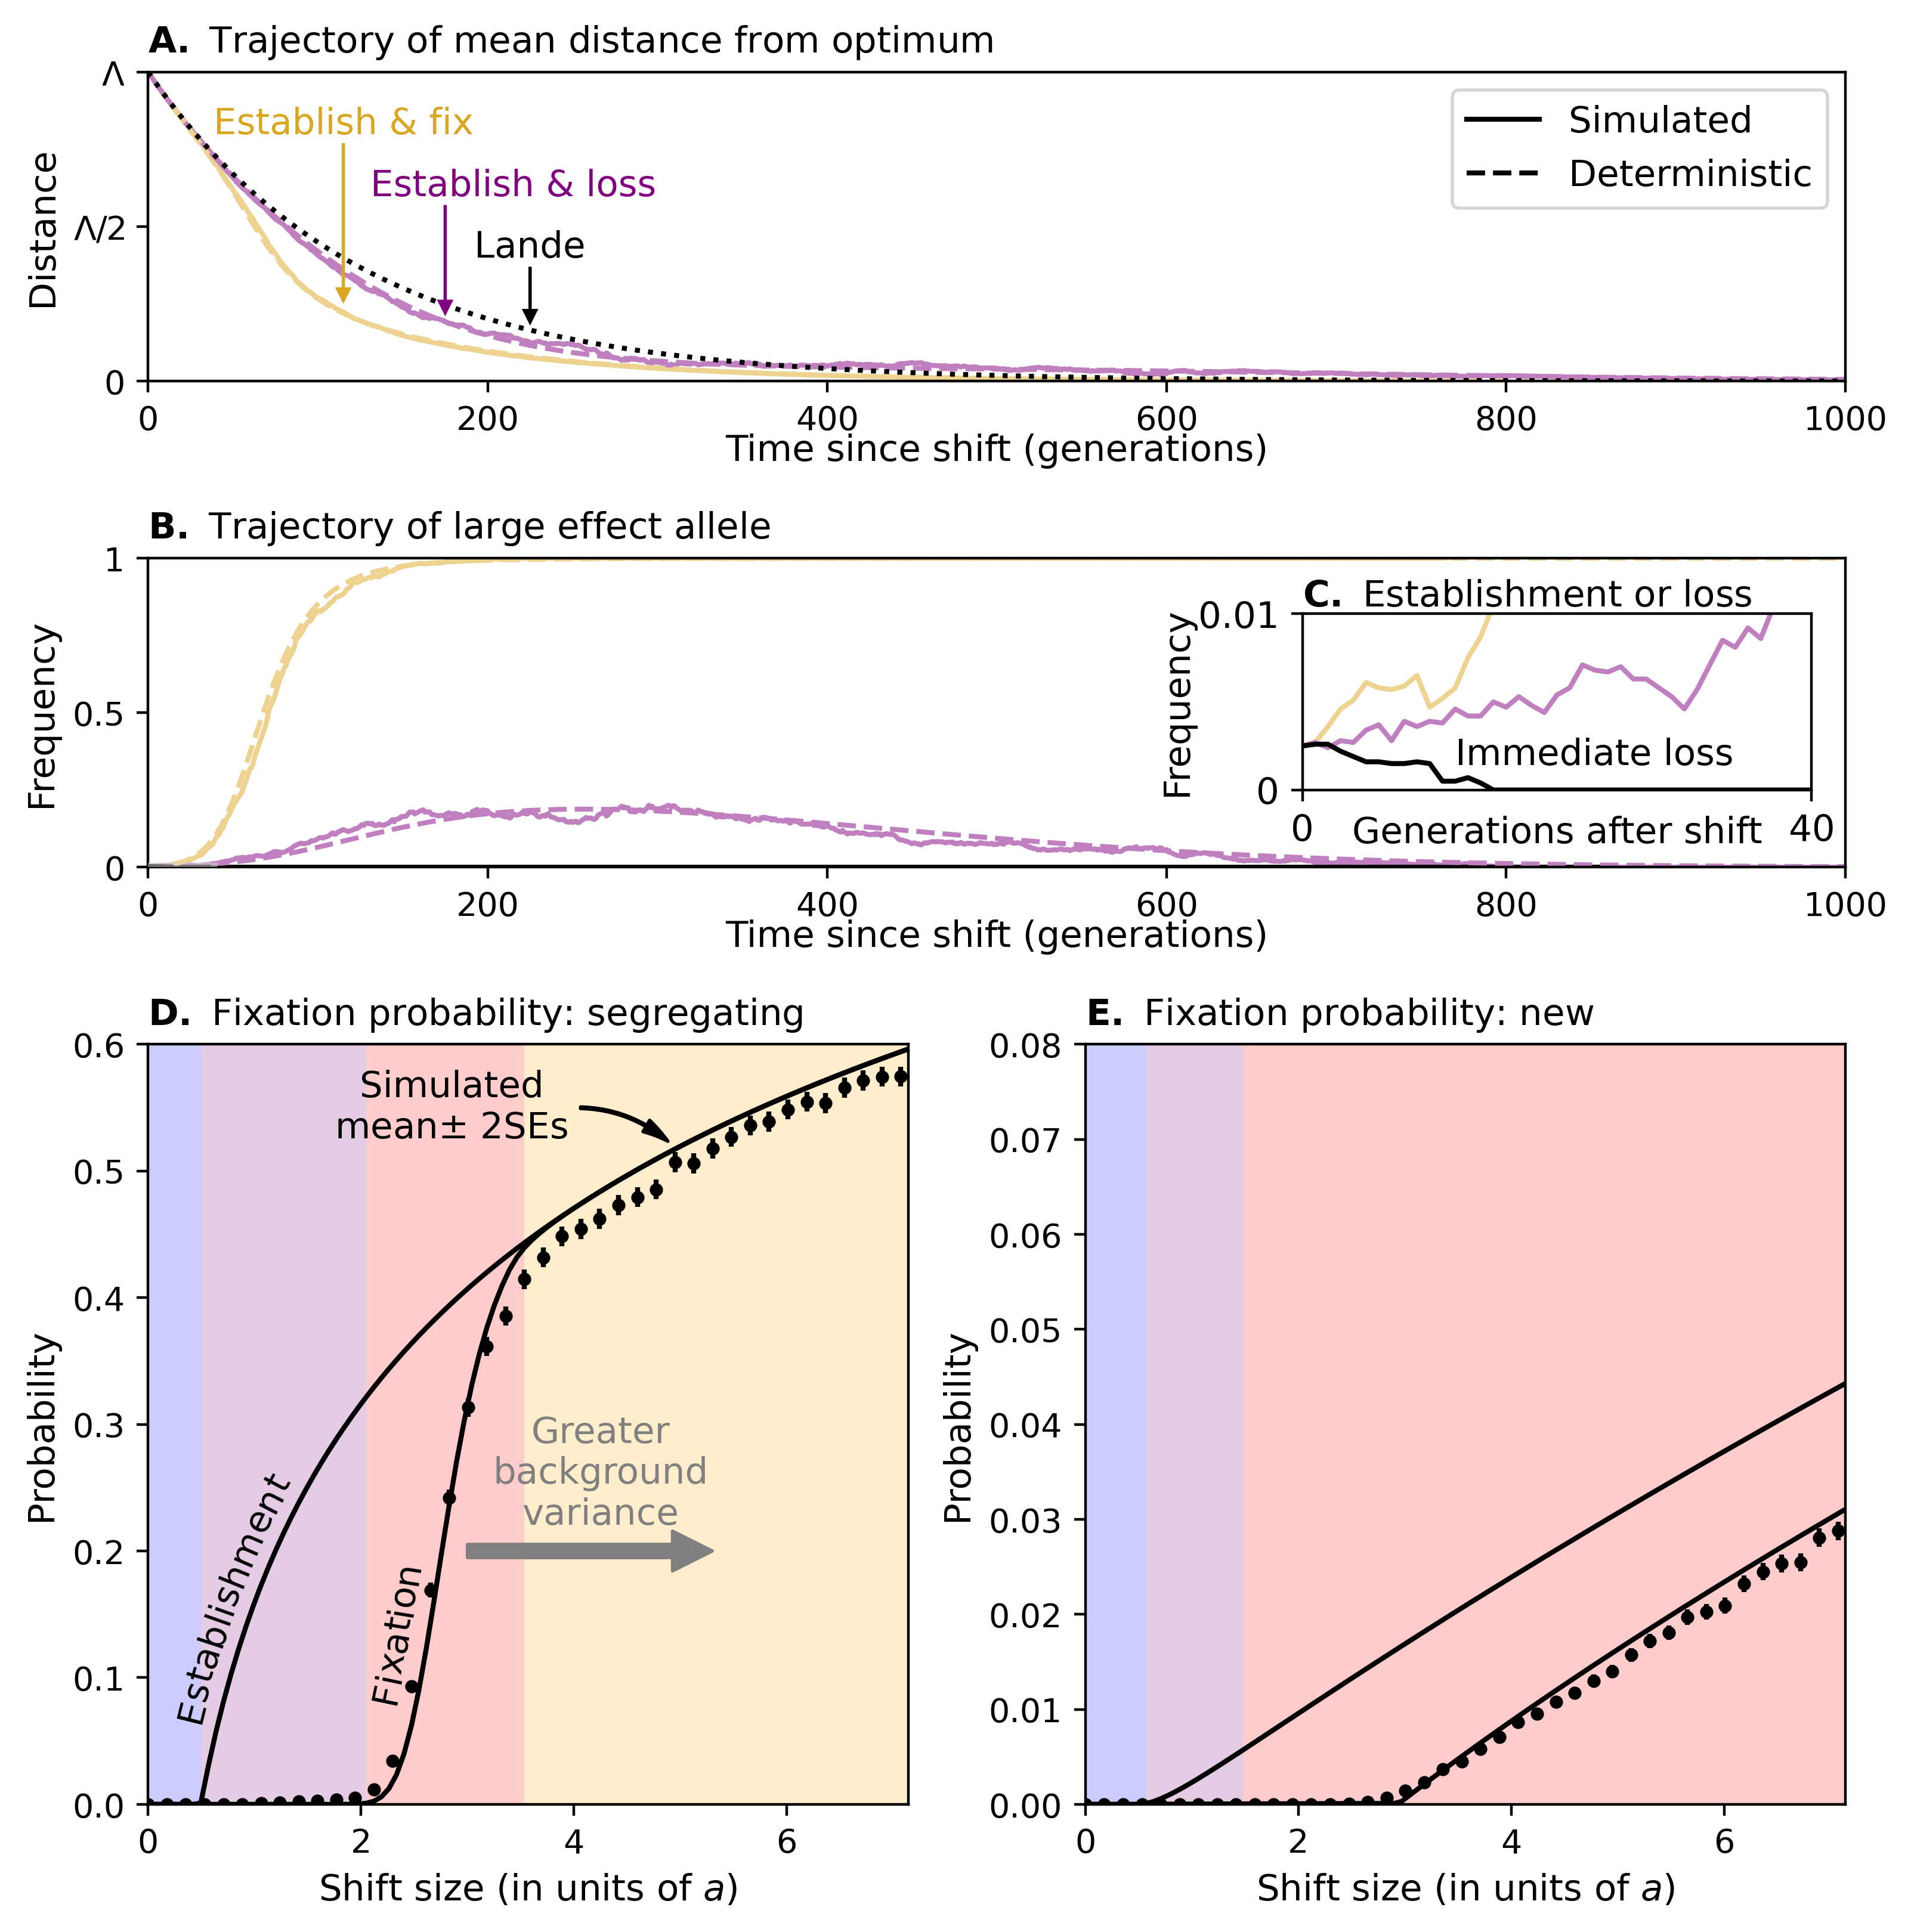

In [11]:
def make_figure_3():
    fig = plt.figure(figsize=(8,8),dpi=400)

    r = fig.canvas.get_renderer()
    t = plt.text(0.5, 0.5, 'test',size=11)
    bb = t.get_window_extent(renderer=r)
    width = bb.width
    height = bb.height/fig.dpi
    t.remove()
    plt.gca().remove()

    upper_pad = 0.01/8
    lower_pad = 0.01/8
    text_pad = height/8

    max_x = 1-text_pad*2
    min_x = 4*text_pad
    min_y = 3*text_pad
    space_for_label_and_ticks = 3*text_pad
    space_between_axes = 0.3/8


    D_x = min_x
    D_y = min_y
    D_width = (max_x-min_x-space_between_axes-space_for_label_and_ticks)/2
    D_height = D_width
    # z = fig.add_axes(rect=[0,0,1,1])
    # z.set_xticks([])
    # z.set_yticks([])
    d = fig.add_axes(rect=[D_x,D_y,D_width,D_height])
    e = fig.add_axes(rect=[D_x+D_width+space_between_axes+space_for_label_and_ticks,D_y,D_width,D_height])

    a_top = 1-text_pad*2
    d_top = D_y+D_height+space_between_axes+space_for_label_and_ticks

    remaining_height = a_top-d_top
    a_height = (remaining_height - space_for_label_and_ticks - space_between_axes)/2
    b_y = d_top
    b_height = a_height
    a_y = b_y+b_height+space_between_axes+space_for_label_and_ticks
    b = fig.add_axes(rect=[D_x,d_top,1-D_x-text_pad*2,a_height])
    a = fig.add_axes(rect=[D_x,a_y,1-D_x-text_pad*2,a_height])

    make_figure_3_right_side([d,e],simulation_results=simulation_results,analytic_results=analytic_results)
    make_figure_3_left_side(ax_d=a,ax_x=b)

    a.set_title(r'$\bf{A.}$ Trajectory of mean distance from optimum',fontsize=11,loc='left')
    b.set_title(r'$\bf{B.}$ Trajectory of large effect allele',fontsize=11,loc='left')
    d.set_title(r'$\bf{D.}$ Fixation probability: segregating',fontsize=11,loc='left')
    e.set_title(r'$\bf{E.}$ Fixation probability: new',fontsize=11,loc='left')
    a.set_ylabel('Distance',fontsize=11)





    # a = fig.add_axes(rect=[a_x,a_y,a_width,a_height])

    # make_figure_3_left_side(ax_d=axes_all["A"],ax_x=axes_all["B"])
    # plt.subplots_adjust(wspace=0.3,hspace=0.7)
    # axes_all["A"].set_ylabel('Distance',fontsize=11)
    a.set_yticks([0,0.5,1])
    a.set_yticklabels(['0',r'$\Lambda / 2$',r'$\Lambda$'])
    a.set_xlabel('Time since shift (generations)',fontsize=11,labelpad=-1)
    b.set_xlabel('Time since shift (generations)',fontsize=11,labelpad=-1)
    b.set_yticks([0,0.5,1])
    # axes_all["B"].set_title(r'$\bf{B.}$ Trajectory of large effect allele',fontsize=11,loc='left')
    # axes_all["A"].set_title(r'$\bf{A.}$ Trajectory of mean distance from optimum',fontsize=11,loc='left')
    # axes_all["C"].set_title(r'$\bf{D.}$ Fixation probability: segregating',fontsize=11,loc='left')
    # axes_all["D"].set_title(r'$\bf{E.}$ Fixation probability: new',fontsize=11,loc='left')
    # plt.subplots_adjust(wspace=0.3,hspace=1.5)
    h1 = mpl.lines.Line2D([],[],color='k',ls='-',alpha=1,linewidth=1.5,label='Simulated')
    h2 = mpl.lines.Line2D([],[],color='k',ls='--',alpha=1,linewidth=1.5,label='Deterministic')
    # # h3 = mpl.lines.Line2D([],[],color='k',ls=':',alpha=1,linewidth=1.5,label='Lande')

    legend_entries = {'Simulated':h1,'Deterministic':h2}
    a.legend(handles=[h1,h2],labels=['Simulated','Deterministic'],loc='upper right',fontsize=11)
    a.text(115,0.8,'Establish & fix',color='goldenrod',size=11,ha='center')
    a.text(215,0.6,'Establish & loss',color='purple',size=11,ha='center')
    a.text(225,0.4,'Lande',color='k',size=11,horizontalalignment='center')

    arrow_pad = 0.03
    a.annotate('', xy=(115, 0.25), xytext=(115, 0.8-arrow_pad),
                arrowprops=dict(facecolor='goldenrod',edgecolor='None',shrink=0,headwidth=5,width=1,headlength=5))
    a.annotate('', xy=(175, 0.21), xytext=(175, 0.6-arrow_pad),
                arrowprops=dict(facecolor='purple',edgecolor='None',shrink=0,headwidth=5,width=1,headlength=5))
    a.annotate('', xy=(225, 0.18), xytext=(225, 0.4-arrow_pad),
                arrowprops=dict(facecolor='k',edgecolor='None',shrink=0,headwidth=5,width=1,headlength=5))


    plt.tight_layout()
    plt.savefig('/Users/will_milligan/Desktop/Sella/Figure_3.png',bbox_inches='tight')
    # print(fig.axes)

make_figure_3()


In [12]:
# generate fixation and establishment probabilities for new and segregating alleles
S = 200
sigma2_values = [40]
sdist = stats.expon(scale=400,loc=100)

def calculate_segregating_fixation_probability_given_S(sigma2,shift,S):
    return calculate_fixation_probability_for_segregating_alleles(S=S,sigma2_values=[sigma2],shift_values=[shift],normalize=False)[sigma2][shift]

def calculate_segregating_fixation_probability_per_mutational_input(sigma2,shift,sdist):
    return quad(lambda S: calculate_segregating_fixation_probability_given_S(sigma2=sigma2,shift=shift,S=S)*sdist.pdf(S),sdist.ppf(0.001),sdist.ppf(0.999))[0]

def calculate_segregating_establishment_probability_given_S(sigma2,shift,S):
    return calculate_establishment_probability_for_segregating_alleles(S=S,sigma2_values=[sigma2],shift_values=[shift],normalize=False)[sigma2][shift]

def calculate_segregating_establishment_probability_per_mutational_input(sigma2,shift,sdist):
    return quad(lambda S: calculate_segregating_establishment_probability_given_S(sigma2=sigma2,shift=shift,S=S)*sdist.pdf(S),sdist.ppf(0.001),sdist.ppf(0.999))[0]

def calculate_min_shifts_for_given_sigma2(sigma2,sdist,n=100):
    min_shift_dict = {}
    try_values = [40,42,43,45]
    for y in np.linspace(0.001,0.999,n):
        S = sdist.ppf(y)
        print(f'Calculating minimum shift for S={S} and sigma2={sigma2}')
        min_shift = find_minimum_shift_for_shift_recursion(sigma2=sigma2,S=S,shift=100,x0=1/(2*N),depth=0,best_guess=100,min_shift=0,max_shift=100,try_values = try_values)
        min_shift_dict[S] = min_shift
        print(f'Minimum shift for S={S} and sigma2={sigma2}: {min_shift}')
        try_values = [min_shift-1,min_shift-0.1,min_shift+0.1,min_shift+1]
    return min_shift_dict

def calculate_new_fixation_probability_given_S(sigma2,shift,S,min_shift_dict={}):
    return calculate_fixation_probability_for_new_alleles(S=S,sigma2_values=[sigma2],shift_values=[shift],normalize=False,min_shift_dict=min_shift_dict)[sigma2][shift]

def calculate_new_fixation_probability_per_mutational_input(sigma2,shift,sdist,min_shift_dict={}):
    return quad(lambda S: calculate_new_fixation_probability_given_S(sigma2=sigma2,shift=shift,S=S,min_shift_dict=min_shift_dict)*sdist.pdf(S),sdist.ppf(0.001),sdist.ppf(0.999))[0]


In [13]:
sdist = stats.expon(scale=400,loc=100)
sigma2_values = [40]
shift_values = np.linspace(0,100,101)

try:
    with open('/Users/will_milligan/Desktop/Sella/segregating_general_model.pickle','rb') as f:
        segregating_general_model = pickle.load(f)
    print('Loaded segregating general model')
except:
    segregating_general_model = {sdist:{sigma2:{shift:{'fixation':0, 'establishment':0} for shift in np.linspace(0,100,101)} for sigma2 in sigma2_values}}

for sdist_temp in [sdist]:
    if sdist_temp not in segregating_general_model.keys():
        segregating_general_model[sdist_temp] = {}
    for sigma2 in sigma2_values:
        if sigma2 not in segregating_general_model[sdist_temp].keys():
            segregating_general_model[sdist_temp][sigma2] = {}
        for shift in np.linspace(0,100,101):
            if shift not in segregating_general_model[sdist_temp][sigma2].keys():
                segregating_general_model[sdist_temp][sigma2][shift] = {'fixation': 0, 'establishment': 0}
            if 'fixation' not in segregating_general_model[sdist_temp][sigma2][shift].keys() or segregating_general_model[sdist_temp][sigma2][shift]['fixation'] == 0:
                segregating_general_model[sdist_temp][sigma2][shift]['fixation']= calculate_segregating_fixation_probability_per_mutational_input(sigma2=sigma2,shift=shift,sdist=sdist)
            if 'establishment' not in segregating_general_model[sdist_temp][sigma2][shift].keys() or segregating_general_model[sdist_temp][sigma2][shift]['establishment'] == 0:
                segregating_general_model[sdist_temp][sigma2][shift]['establishment'] = calculate_segregating_establishment_probability_per_mutational_input(sigma2=sigma2,shift=shift,sdist=sdist)
            print('fixation and establishment probabilities for segregating alleles calculated for sigma2={}, shift={}'.format(sigma2,shift),'are {}'.format(segregating_general_model[sdist_temp][sigma2][shift]))


Loaded segregating general model


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in double_scalars
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:382: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  # Remove the CWD from sys.path while we load stuff.


fixation and establishment probabilities for segregating alleles calculated for sigma2=40, shift=0.0 are {'fixation': nan, 'establishment': 0.0}
fixation and establishment probabilities for segregating alleles calculated for sigma2=40, shift=1.0 are {'fixation': 1.3454198125850089e-14, 'establishment': 1.237788297517082e-13}
fixation and establishment probabilities for segregating alleles calculated for sigma2=40, shift=2.0 are {'fixation': 4.124758282246645e-14, 'establishment': 1.33006568988198e-12}
fixation and establishment probabilities for segregating alleles calculated for sigma2=40, shift=3.0 are {'fixation': 7.465571599608718e-14, 'establishment': 1.368868252426814e-10}
fixation and establishment probabilities for segregating alleles calculated for sigma2=40, shift=4.0 are {'fixation': 1.2095168861544043e-13, 'establishment': 7.721394699552853e-08}
fixation and establishment probabilities for segregating alleles calculated for sigma2=40, shift=5.0 are {'fixation': 1.9366501648

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.


fixation and establishment probabilities for segregating alleles calculated for sigma2=40, shift=10.0 are {'fixation': 6.205603912297062e-12, 'establishment': 0.33257063758068167}


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: IntegrationWarning: The integral is probably divergent, or slowly convergent.


fixation and establishment probabilities for segregating alleles calculated for sigma2=40, shift=11.0 are {'fixation': 1.6822955135511174e-11, 'establishment': 0.4407746474852027}
fixation and establishment probabilities for segregating alleles calculated for sigma2=40, shift=12.0 are {'fixation': 4.982464253481933e-11, 'establishment': 0.5537199320806225}
fixation and establishment probabilities for segregating alleles calculated for sigma2=40, shift=13.0 are {'fixation': 1.5796218792407034e-10, 'establishment': 0.6688588749139802}
fixation and establishment probabilities for segregating alleles calculated for sigma2=40, shift=14.0 are {'fixation': 5.316158565117227e-10, 'establishment': 0.7841922216923163}
fixation and establishment probabilities for segregating alleles calculated for sigma2=40, shift=15.0 are {'fixation': 1.8581326400991534e-09, 'establishment': 0.8982045614095389}
fixation and establishment probabilities for segregating alleles calculated for sigma2=40, shift=16.0 

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  # Remove the CWD from sys.path while we load stuff.


fixation and establishment probabilities for segregating alleles calculated for sigma2=40, shift=25.0 are {'fixation': 0.00029804443225207595, 'establishment': 1.8492565454414789}
fixation and establishment probabilities for segregating alleles calculated for sigma2=40, shift=26.0 are {'fixation': 0.0007597538096282034, 'establishment': 1.9249594507035315}
fixation and establishment probabilities for segregating alleles calculated for sigma2=40, shift=27.0 are {'fixation': 0.0018145855860184185, 'establishment': 1.9977969230295138}
fixation and establishment probabilities for segregating alleles calculated for sigma2=40, shift=28.0 are {'fixation': 0.0040674130641842636, 'establishment': 2.067937582009081}
fixation and establishment probabilities for segregating alleles calculated for sigma2=40, shift=29.0 are {'fixation': 0.008563670341785654, 'establishment': 2.1355592904360634}
fixation and establishment probabilities for segregating alleles calculated for sigma2=40, shift=30.0 are 

In [ ]:
with open('/Users/will_milligan/Desktop/Sella/segregating_general_model.pickle','wb') as f:
    pickle.dump(segregating_general_model,f)


ValueError: stop

In [16]:
try:
    with open('/Users/will_milligan/Desktop/Sella/min_shift_dict.pickle','rb') as f:
        min_shift_dict = pickle.load(f)
except:
    min_shift_dict=calculate_min_shifts_for_given_sigma2(sigma2=40,sdist=sdist,n=100)


Calculating minimum shift for S=100.40020013343342 and sigma2=40
Minimum shift for sigma2=40, S=100.40020013343342: 42 to 43 with best guess 43, current shift 45
Minimum shift for sigma2=40, S=100.40020013343342: 42.5 to 43 with best guess 43, current shift 42.5
Minimum shift for sigma2=40, S=100.40020013343342: 42.5 to 42.75 with best guess 42.75, current shift 42.75
Minimum shift for sigma2=40, S=100.40020013343342: 42.5 to 42.625 with best guess 42.625, current shift 42.625
Minimum shift for sigma2=40, S=100.40020013343342: 42.5625 to 42.625 with best guess 42.625, current shift 42.5625
Minimum shift for S=100.40020013343342 and sigma2=40: 42.625
Calculating minimum shift for S=104.4570630215354 and sigma2=40
Minimum shift for sigma2=40, S=104.4570630215354: 41.625 to 42.525 with best guess 42.525, current shift 43.625
Minimum shift for sigma2=40, S=104.4570630215354: 42.075 to 42.525 with best guess 42.525, current shift 42.075
Minimum shift for sigma2=40, S=104.4570630215354: 42.3

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:293: RuntimeWarning: overflow encountered in exp


Minimum shift for sigma2=40, S=1901.0162675366007: 57.953909397125315 to 78.97695469856265 with best guess 78.97695469856265, current shift 78.97695469856265
Minimum shift for sigma2=40, S=1901.0162675366007: 57.953909397125315 to 68.46543204784399 with best guess 68.46543204784399, current shift 68.46543204784399
Minimum shift for sigma2=40, S=1901.0162675366007: 57.953909397125315 to 63.20967072248465 with best guess 63.20967072248465, current shift 63.20967072248465
Minimum shift for sigma2=40, S=1901.0162675366007: 57.953909397125315 to 60.58179005980499 with best guess 60.58179005980499, current shift 60.58179005980499
Minimum shift for sigma2=40, S=1901.0162675366007: 59.26784972846515 to 60.58179005980499 with best guess 60.58179005980499, current shift 59.26784972846515
Minimum shift for sigma2=40, S=1901.0162675366007: 59.26784972846515 to 59.92481989413507 with best guess 59.92481989413507, current shift 59.92481989413507
Minimum shift for sigma2=40, S=1901.0162675366007: 59.

In [18]:
with open('/Users/will_milligan/Desktop/Sella/min_shift_dict.pickle','wb') as f:
    pickle.dump(min_shift_dict,f)


In [20]:
new_general_model = {}
for sdist_temp in [sdist]:
    if sdist_temp not in new_general_model.keys():
        new_general_model[sdist_temp] = {} 
    for sigma2 in [40]:
        if sigma2 not in new_general_model[sdist_temp].keys():
            new_general_model[sdist_temp][sigma2] = {}
        for shift in np.linspace(0,100,101):
            print(shift)
            if shift not in new_general_model[sdist_temp][sigma2].keys():
                new_general_model[sdist_temp][sigma2][shift] = {}
            if 'fixation' not in new_general_model[sdist_temp][sigma2][shift].keys() or new_general_model[sdist_temp][sigma2][shift]['fixation'] == 0:
                new_general_model[sdist_temp][sigma2][shift]['fixation'] = calculate_new_fixation_probability_per_mutational_input(sigma2=sigma2,shift=shift,sdist=sdist,min_shift_dict={40:min_shift_dict})
            if 'establishment' not in new_general_model[sdist_temp][sigma2][shift].keys() or new_general_model[sdist_temp][sigma2][shift]['establishment'] == 0:
                new_general_model[sdist_temp][sigma2][shift]['establishment'] = quad(lambda S: calculate_establishment_probability_for_new_alleles(S=S,sigma2_values=[sigma2],shift_values=[shift],normalize=False)[sigma2][shift]*sdist.pdf(S),sdist.ppf(0.001),sdist.ppf(0.999))[0]


0.0
1.0
2.0
3.0
4.0
5.0
6.0


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0


In [33]:
all_analytics = {}
for key in segregating_general_model.keys():
    for sigma2 in segregating_general_model[key].keys():
        all_analytics[sigma2] = {}
        for shift in segregating_general_model[key][sigma2].keys():
            try:
                all_analytics[sigma2][shift] = {'seg': {'establish': segregating_general_model[key][sigma2][shift]['establishment']},'fixation': segregating_general_model[key][sigma2][shift]['fixation']}
            except:
                all_analytics[sigma2][shift] = {'seg': {'establish': 0},'fixation': 0}
for key in new_general_model.keys():
    for sigma2 in new_general_model[key].keys():
        for shift in new_general_model[key][sigma2].keys():
            try:
                all_analytics[sigma2][shift]['new'] = {'establish': new_general_model[key][sigma2][shift]['establishment'],'fixation': new_general_model[key][sigma2][shift]['fixation']}
            except:
                all_analytics[sigma2][shift]['new'] = {'establish': 0,'fixation': 0}


In [21]:
### Figure 4C results

figure4C_results = {}
sigma2 = 40
sdist = stats.expon(scale=400,loc=100)
N = 5000
for shift in np.linspace(5,100,39):
    print(shift)
    seg_established = quad(lambda S: quad(lambda x: folded_sojourn_time(S=S,x=x)*establishment_prob(S=S,shift=shift,x=x),0,1/2,points=[1/(2*N)])[0]*sdist.pdf(S),sdist.ppf(0),sdist.ppf(0.9999))[0]
    new_established = quad(lambda S: quad(lambda t: establishment_prob(S=S,shift=shift*np.exp(-sigma2/(2*N)*t),x=1/(2*N)),0,max(1,np.log(2*shift/np.sqrt(S))*2*N/sigma2))[0]*sdist.pdf(S),sdist.ppf(0),sdist.ppf(0.9999))[0]
    figure4C_results[shift] = (seg_established,new_established)


5.0
7.5


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  if __name__ == '__main__':


10.0
12.5
15.0
17.5
20.0
22.5
25.0
27.5
30.0
32.5
35.0
37.5
40.0
42.5
45.0
47.5
50.0
52.5
55.0
57.5
60.0
62.5
65.0
67.5
70.0
72.5
75.0
77.5
80.0
82.5
85.0
87.5
90.0
92.5
95.0
97.5
100.0


1.9539496527777773 1.9447889787434898


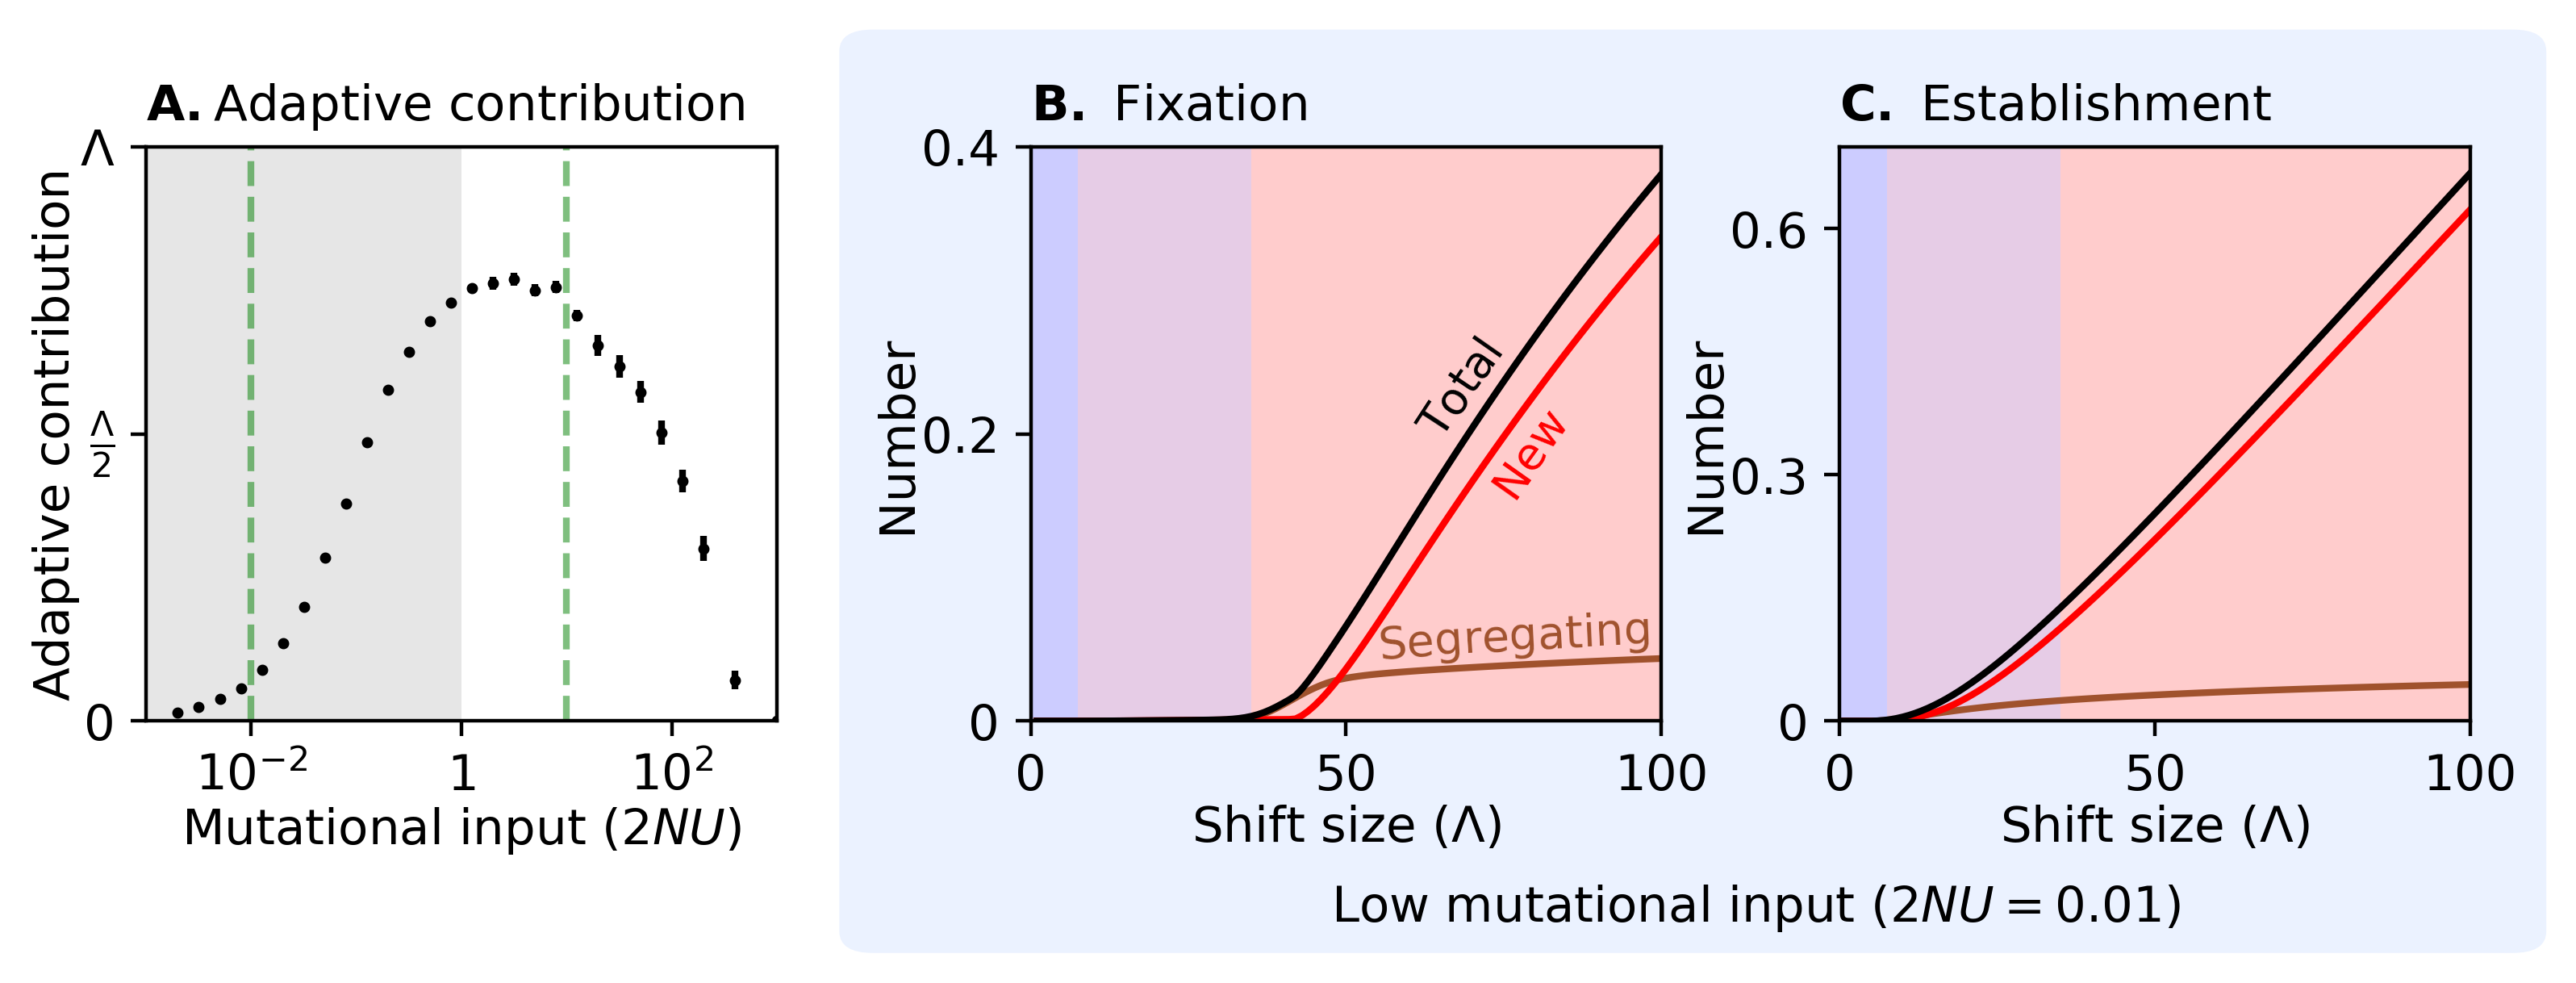

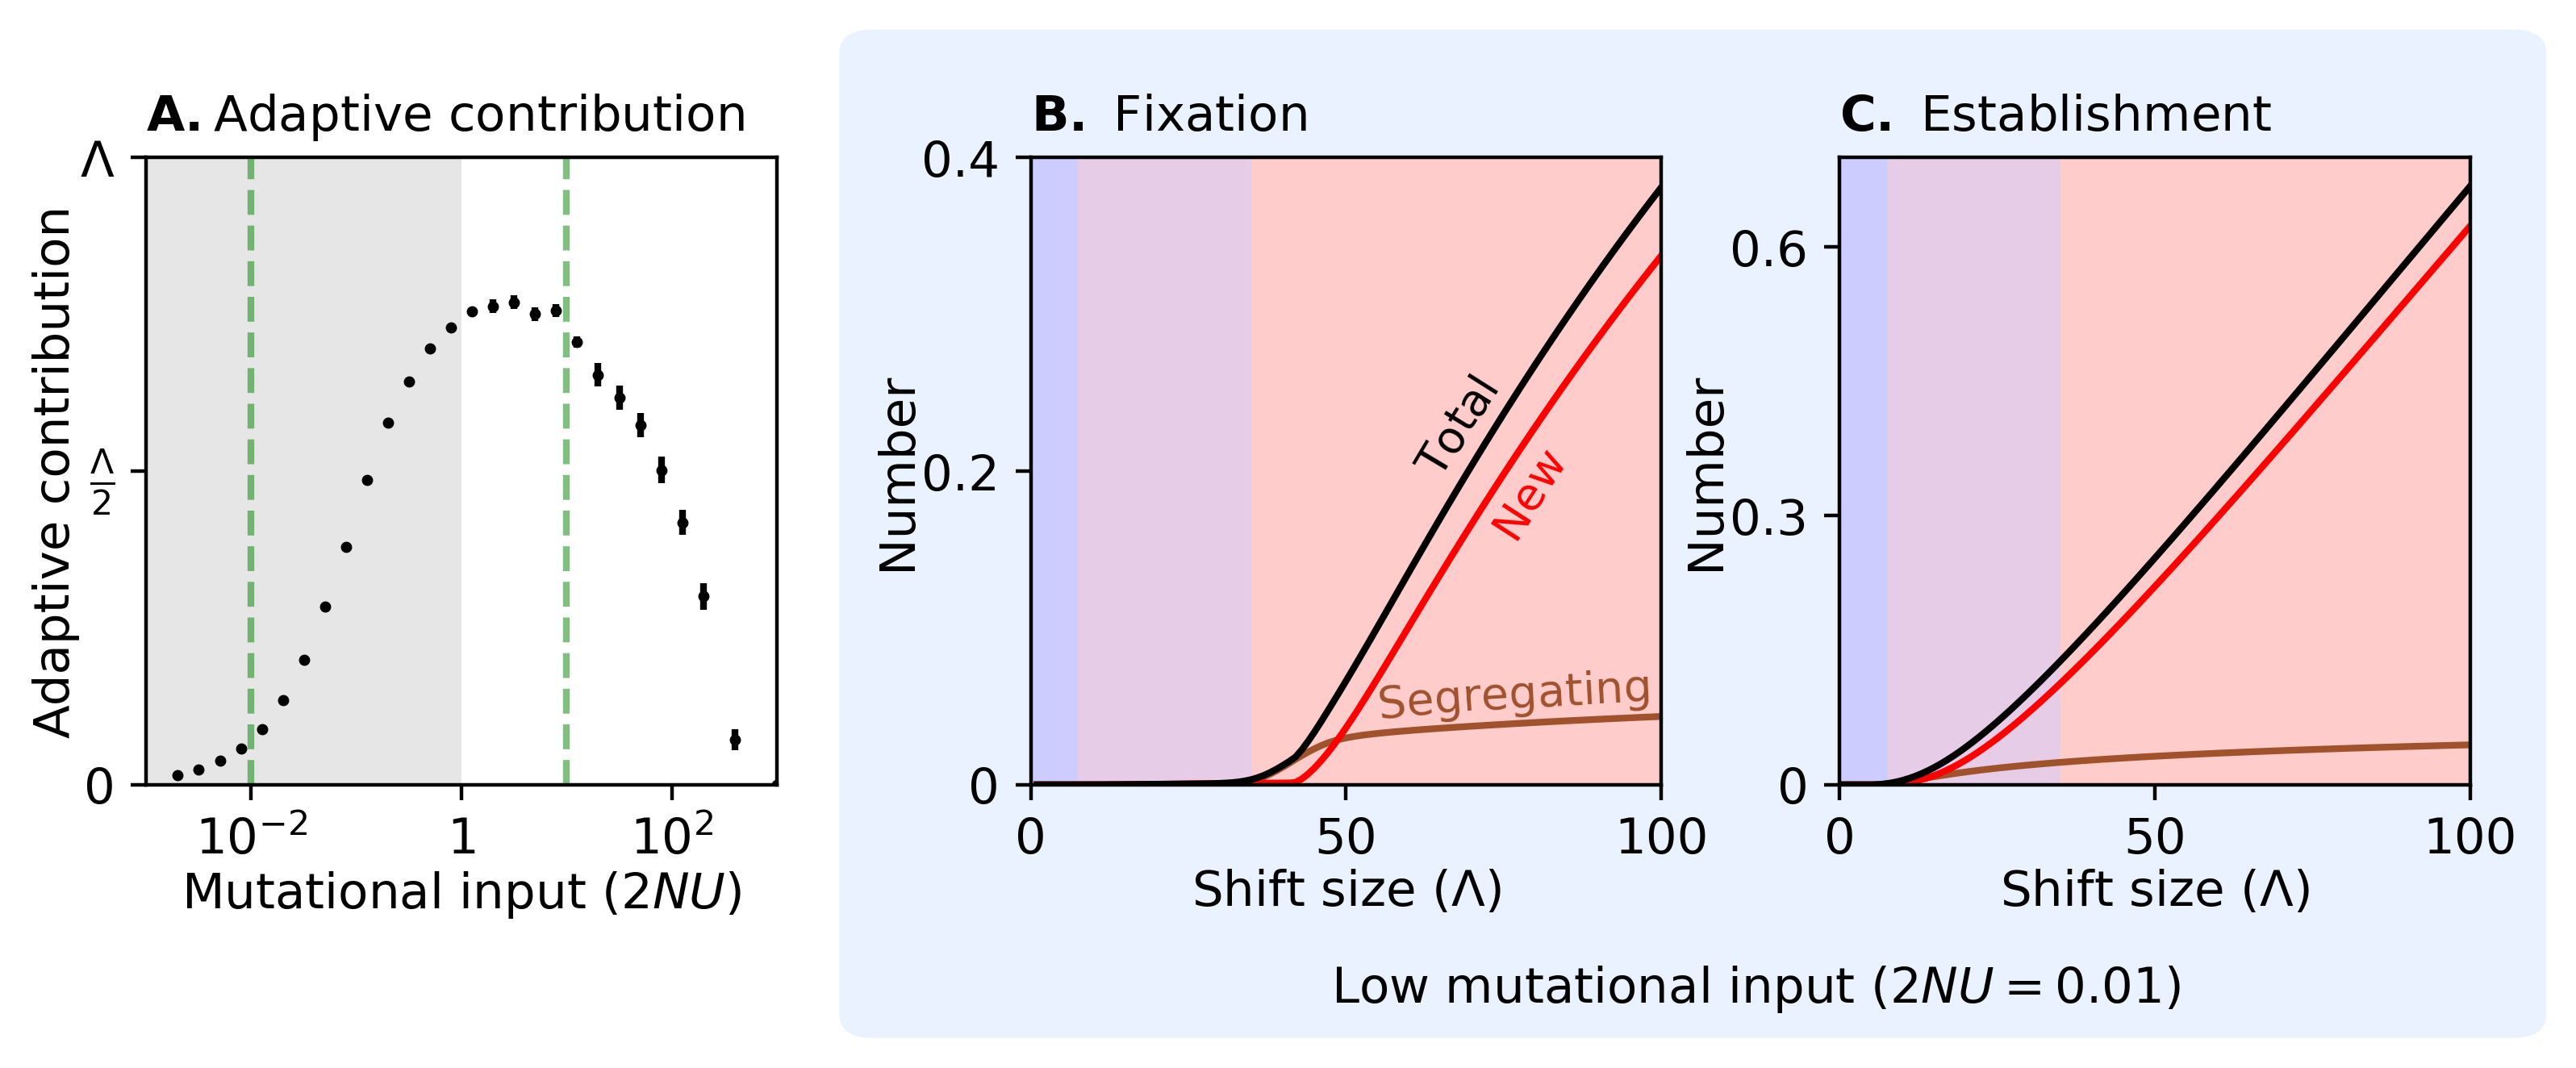

In [34]:
internal_fontsize = 10
external_fontsize = 11
max_y = 0.7
new_color = 'red'
seg_color = 'sienna'

### filepath for simulated fixation results
### should have a structure like: {N2U: {sigma2: {shift: {'fixations': results}}}}
simulated_fixation_results_path = '/Users/will_milligan/Desktop/Sella/Figure_4_simulations_summary_all.pickle'

### filepath for analytic fixation results
### should have a structure like: {sigma2: {shift: {seg/new: {fix/establish: result}}}}
analytic_fixation_results_path = '/Users/will_milligan/Desktop/Sella/Figure_4_analytic_summary_all.pickle'

def make_figure4A(ax,example_inputs = [0.01,10]):
    
    ### plot adaptation results
    with open('/Users/will_milligan/Desktop/Sella/Figure_4_A_simulations_summary_all.pickle','rb') as fin:
        all_simulations = pickle.load(fin)

    for N2U in all_simulations.keys():
        results = all_simulations[N2U][40][80]['fixations']['adaptation']
        adaptation = np.array(results)
        adaptation_mean,adaptation_ste = np.mean(adaptation)/80,2*np.std(adaptation)/np.sqrt(len(adaptation))/80
        ax.errorbar(2*N2U,adaptation_mean,yerr=adaptation_ste,marker='.',color='k',markersize=3)
    
    ### plot lines for example mutational inputs
    for N2U in example_inputs:
        ax.plot([N2U,N2U],[0,1],color='green',ls='--',alpha=0.5)
        
    ### set up labels and titles and ticks
    ax.set_title(r'$\bf{A.}$' + 'Adaptive contribution',fontsize=external_fontsize,loc='left')
    ax.set_xscale('log')
    ax.set_xlim([1e-3,1e3])
    ax.set_xticks([1e-2,1e0,1e2])
    ax.set_xticklabels([r'$10^{-2}$',r'$1$',r'$10^{2}$'],fontsize=external_fontsize)
    ax.set_xlabel(r'Mutational input ($2NU$)',fontsize=external_fontsize,labelpad=1)
    ax.set_ylim([0,1])
    ax.set_yticks([0,0.5,1])
    ax.set_yticklabels(['0',r'$\frac{\Lambda}{2}$',r'$\Lambda$'],fontsize=external_fontsize)
    ax.set_ylabel(r'Adaptive contribution',fontsize=external_fontsize,labelpad=0)
    ax.fill_between([1e-3,1],[0,0],[1,1],color=[0.9,0.9,0.9],edgecolor='None',zorder=0)
    
def make_figure4C(ax,figure4C_results,N2U = 0.01):
    
    ### plot analytic results for establishment probabilities
    # with open(analytic_fixation_results_path,'rb') as fin:
    #     all_analytics = pickle.load(fin)
    
    
                    
    sigma2 = 40
    x_values = np.sort(list(all_analytics[sigma2].keys()))

    seg_values = []
    new_values = []
    for x in x_values:
        seg = all_analytics[sigma2][x]['seg']['establish']
        new = all_analytics[sigma2][x]['new']['establish']
        seg_values.append(seg*N2U)
        
        new_values.append(N2U*new)

    ax.plot(x_values,seg_values,color=seg_color)
    ax.plot(x_values,new_values,color=new_color)
    ax.plot(x_values,np.array(seg_values)+np.array(new_values),color='k')
    
    # set up labels and titles and ticks
    ax.set_title(r'$\bf{C.}$ Establishment',fontsize=external_fontsize,loc='left')
    ax.set_xlim([0,100])
    ax.set_xticks([0,50,100])
    ax.set_xticklabels([0,50,100],fontsize=external_fontsize)
    ax.set_xlabel(r'Shift size ($\Lambda$)',fontsize=external_fontsize,labelpad=1)
    ax.set_ylim([0,max_y])
    ax.set_yticks([0,0.3,0.6])
    ax.set_yticklabels(['0','0.3','0.6'],fontsize=external_fontsize)
    ax.set_ylabel('Number',fontsize=external_fontsize,labelpad=0)
    
    ### draw background regions
    x_values = [0]+[i for i in figure4C_results.keys()]
    y_values = [0]+[(i[0]+i[1])*N2U for i in figure4C_results.values()]
        
    ## find establishment boundary
    ### find index where y_values > 0.01
    establishment_boundary = x_values[np.where(np.array(y_values) > 0.001)[0][0]]
    ax.fill_between([0,establishment_boundary],[0,0],[max_y,max_y],color=[0.8,0.8,1],edgecolor='None')
    
    fixed_boundary = 35
    ax.fill_between([establishment_boundary,fixed_boundary],[0,0],[max_y,max_y],color=[0.5*0.2+0.8,0.8,0.5*0.2+0.8],edgecolor='None')
    ax.fill_between([fixed_boundary,100],[0,0],[max_y,max_y],color=[1,0.8,0.8],edgecolor='None')
    
def make_figure4B(ax,figure4C_results,N2U = 0.01,sigma2=40):
    
    ### plot background regions
    x_values = [0]+[i for i in figure4C_results.keys()]
    y_values = [0]+[(i[0]+i[1])*N2U for i in figure4C_results.values()]
    
    ## find establishment boundary
    ### find index where y_values > 0.01
    establishment_boundary = x_values[np.where(np.array(y_values) > 0.001)[0][0]]
    ax.fill_between([0,establishment_boundary],[0,0],[max_y,max_y],color=[0.8,0.8,1],edgecolor='None')
    
    fixed_boundary = 35
    
    ax.fill_between([establishment_boundary,fixed_boundary],[0,0],[max_y,max_y],color=[0.5*0.2+0.8,0.8,0.5*0.2+0.8],edgecolor='None')
    ax.fill_between([fixed_boundary,100],[0,0],[max_y,max_y],color=[1,0.8,0.8],edgecolor='None')
    
    ### plot simulated fixation results
    with open(simulated_fixation_results_path,'rb') as fin:
        all_simulations = pickle.load(fin)

    for shift in all_simulations[N2U][sigma2].keys():
        results = all_simulations[N2U][sigma2][shift]['fixations']
        total_fixed = np.array(results['number'])
        
        total_fixed_seg = np.array(results['num_segregating'])
        total_fixed_new = total_fixed - total_fixed_seg
        
        total_fixed_mean,total_fixed_ste = np.mean(total_fixed),2*np.std(total_fixed)/np.sqrt(len(total_fixed))
        total_fixed_seg_mean,total_fixed_seg_ste = np.mean(total_fixed_seg),2*np.std(total_fixed_seg)/np.sqrt(len(total_fixed_seg))
        total_fixed_new_mean,total_fixed_new_ste = np.mean(total_fixed_new),2*np.std(total_fixed_new)/np.sqrt(len(total_fixed_new))
        # ax.errorbar(shift,total_fixed_seg_mean,yerr=total_fixed_seg_ste,marker='.',color=seg_color,markersize=2)
        # ax.errorbar(shift,total_fixed_new_mean,yerr=total_fixed_new_ste,marker='.',color=new_color,markersize=2)
        # ax.errorbar(shift,total_fixed_mean,yerr=total_fixed_ste,marker='.',color='k',markersize=2)
        
    # ## plot analytic results for fixation probabilities
    # with open(analytic_fixation_results_path,'rb') as fin:
    #     all_analytics = pickle.load(fin)

    # x_values = np.sort(list(all_analytics[sigma2].keys()))

    # seg_values = []
    # new_values = []
    # for x in x_values:
    #     seg = all_analytics[sigma2][x]['seg']['fix']
    #     new = all_analytics[sigma2][x]['new']['fix']
    #     seg_values.append(seg*N2U)
        
    #     new_values.append(np.exp(-seg*N2U)*(1-np.exp(-N2U*new)))
        
    # ### plot fixation analytic results
    # ax.plot(x_values,seg_values,color=seg_color)
    # ax.plot(x_values,new_values,color=new_color)
    # ax.plot(x_values,np.array(seg_values)+np.array(new_values),color='k')
    
    sdist_seg = list(segregating_general_model.keys())[0]
    sdist_new = list(new_general_model.keys())[0]
    x_values = segregating_general_model[sdist_seg][sigma2].keys()
    seg_values = [1-np.exp(-segregating_general_model[sdist_seg][sigma2][x]['fixation']*N2U) for x in x_values]
    new_values = [np.exp(-segregating_general_model[sdist_seg][sigma2][x]['fixation']*N2U)*(1-np.exp(-N2U*new_general_model[sdist_new][sigma2][x]['fixation'])) for x in x_values]
    ax.plot(x_values,seg_values,color=seg_color)
    ax.plot(x_values,new_values,color=new_color)
    ax.plot(x_values,np.array(seg_values)+np.array(new_values),color='k')
    ### Label lines
    text = CurvedText(
            x = np.array([x for x in x_values if x > 53])+0.25,
            y = np.array([y for x,y in zip(x_values,seg_values) if x>50])+0.005,
            text='Segregating',
            va = 'bottom',
            color=seg_color,
            alpha=1,
            axes = ax,
            fontsize=internal_fontsize,
        )
    text = CurvedText(
            x = [x for x in x_values if x > 70],
            y = np.array([y for x,y in zip(x_values,new_values) if x>70])-0.01,
            text='New',
            va = 'top',
            color=new_color,
            alpha=1,
            axes = ax,
            fontsize=internal_fontsize,
        )
    text = CurvedText(
            x = [x for x in x_values if x > 65],
            y = np.array([s+n for x,s,n in zip(x_values,seg_values,new_values) if x>65])+0.01,
            text='Total',
            va = 'bottom',
            color='k',
            alpha=1,
            axes = ax,
            fontsize=internal_fontsize,
        )

    ### do a bunch of modifications to the axes limits, labels, ticks, and titles
    ax.set_title(r'$\bf{B.}$ Fixation',fontsize=external_fontsize,loc='left')
    ax.set_xlim([0,100])
    ax.set_xticks([0,50,100])
    ax.set_xticklabels([0,50,100],fontsize=external_fontsize)
    ax.set_xlabel(r'Shift size ($\Lambda$)',fontsize=external_fontsize,labelpad=1)
    ax.set_ylim([0,0.4])
    ax.set_yticks([0,0.2,0.4])
    ax.set_yticklabels(['0','0.2','0.4'],fontsize=external_fontsize)
    ax.set_ylabel(r'Number',fontsize=external_fontsize,labelpad=0)
       
def make_figure_4(figsize=(8,2.7)):
    
    ### set up figure
    fig,axes = plt.subplots(nrows=1,ncols=5,figsize=figsize,dpi=400,gridspec_kw={'width_ratios': [25,4,25,1,25]})
    ### turn off spacing axes
    axes[1].axis('off')
    axes[3].axis('off')
    axes = [axes[0],axes[2],axes[4]]
    
    ### draw the background regions and plot establishment and fixation results
    make_figure4C(axes[2],figure4C_results)
    make_figure4B(axes[1],figure4C_results)
    ### plot adaptation results
    make_figure4A(axes[0],example_inputs=[0.01,10])
    
    plt.subplots_adjust(wspace=0)
    plt.tight_layout(w_pad=-1.8)    
    
    fig.canvas.draw()
    
    ### add a rounded rectangle around B and C
    rounded_rect = FancyBboxPatch((-30, -0.16), 270, 0.64, boxstyle='Round, pad=0,rounding_size=5', mutation_aspect=0.8/300,color=[0.92,0.95,1],edgecolor=None,clip_on=False,zorder=0)
    axes[1].add_patch(rounded_rect)
    axes[1].text(x=115,y=-0.13,s=r'Low mutational input ($2NU=0.01$)',color='k',fontsize=external_fontsize,rotation=0,va='center',ha='center',clip_on=False)

    fig.canvas.draw()
    
    ## get dimensions of the axes
    bbox = axes[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width, height = bbox.width, bbox.height
    plt.savefig('/Users/will_milligan/Desktop/Sella/Figure_4.png',bbox_inches='tight',dpi=400)
    return width,height

width,height = make_figure_4()
height_fig = 2.7
width_fig = 8
while not np.isclose(width,height,rtol=0.005):
    height_fig = height_fig*width/height
    width,height = make_figure_4(figsize=(width_fig,height_fig))
    if not np.isclose(width,height,rtol=0.005):
        plt.close()
print(width,height)
